<a href="https://colab.research.google.com/github/JAGAN666/SEC-Corporate-Filings-Insights-/blob/main/SEC_Corporate_Filings_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Connections and Improting Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/Project 2"


2018q1	2018q2	2018q3	2018q4	company_data.csv  financial_metrics.csv  relationship_data.csv


In [ ]:
import os

# Path to the base SEC data folder
base_folder = '/content/drive/MyDrive/Project 2/'

# List the files in each quarter
for quarter in ['2018q1', '2018q2', '2018q3', '2018q4']:
    quarter_path = os.path.join(base_folder, quarter)
    print(f"Files in {quarter}: {os.listdir(quarter_path)}")


Files in 2018q1: ['sub.txt', 'tag.txt', 'pre.txt', 'num.txt', 'readme.htm']
Files in 2018q2: ['sub.txt', 'tag.txt', 'pre.txt', 'num.txt', 'readme.htm', '.DS_Store']
Files in 2018q3: ['sub.txt', 'tag.txt', 'pre.txt', 'num.txt', 'readme.htm']
Files in 2018q4: ['sub.txt', 'tag.txt', 'pre.txt', 'num.txt', 'readme.htm']


###Loading Dataset

In [ ]:
import os
import pandas as pd

# Define the base folder where the quarterly data is stored
base_folder = '/content/drive/MyDrive/Project 2/'

# List of quarter sub-folders
quarters = ['2018q1', '2018q2', '2018q3', '2018q4']

# File names to be processed
file_names = ['tag.txt', 'sub.txt', 'pre.txt', 'num.txt']

# Initialize dictionaries to store dataframes for each file type
dataframes = {file_name: [] for file_name in file_names}

# Function to load SEC file
def load_sec_file(file_path):
    # Adjust separator or header arguments based on the structure of your files
    return pd.read_csv(file_path, sep='\t', dtype=str)

# Loop over each quarter and load the corresponding files
for quarter in quarters:
    quarter_path = os.path.join(base_folder, quarter)

    for file_name in file_names:
        file_path = os.path.join(quarter_path, file_name)
        df = load_sec_file(file_path)

        # Append the loaded dataframe to the list for that file type
        dataframes[file_name].append(df)

# Concatenate all quarters' data for each file type
combined_dfs = {file_name: pd.concat(dataframes[file_name], ignore_index=True) for file_name in file_names}



###Interpreting the Combined shapes

In [ ]:
# Check the shape of the combined sub.txt data
print("Shape of combined sub.txt:", combined_dfs['sub.txt'].shape)
print("Shape of combined tag.txt:", combined_dfs['tag.txt'].shape)
print("Shape of combined pre.txt:", combined_dfs['pre.txt'].shape)
print("Shape of combined num.txt:", combined_dfs['num.txt'].shape)
print("Preview of combined sub.txt:")
print(combined_dfs['sub.txt'].head())

# Preview the combined data for num.txt
print("Preview of combined num.txt:")
print(combined_dfs['num.txt'].head())
print("Preview of combined tag.txt:")
print(combined_dfs['tag.txt'].head())
print("Preview of combined pre.txt:")
print(combined_dfs['pre.txt'].head())


Shape of combined sub.txt: (26396, 36)
Shape of combined tag.txt: (309650, 9)
Shape of combined pre.txt: (3884740, 10)
Shape of combined num.txt: (9851780, 9)
Preview of combined sub.txt:
                   adsh      cik                    name   sic countryba  \
0  0001062993-17-005393  1606364  GARMATEX HOLDINGS LTD.  1000        US   
1  0001493152-18-000030  1392694    SURGE HOLDINGS, INC.  7310        US   
2  0001562762-17-000231   863894               VERU INC.  3060        US   
3  0001599916-18-000002  1634293      EXCEED WORLD, INC.  6770        JP   
4  0001640334-18-000025  1619227          CLOUDWEB, INC.  7370        GB   

  stprba        cityba       zipba                             bas1  \
0     NV     LAS VEGAS  89123-4300           1853 KING BEACH AVENUE   
1     NV     HENDERSON       89052           10624 S. EASTERN AVE.,   
2     FL         MIAMI       33137          4400 BISCAYNE BOULEVARD   
3    NaN         OSAKA    564-0063  1-23-38-6F, ESAKACHO, SUITA-SHI   


###Extracting, Filtering and Cleaning to obtain the Golden Dataset


In [ ]:
import pandas as pd
import numpy as np

# Step 1: Data Cleaning
sub = combined_dfs['sub.txt']
num = combined_dfs['num.txt']
tag = combined_dfs['tag.txt']
pre = combined_dfs['pre.txt']

# Drop null values in critical columns
sub = sub.dropna(subset=['adsh', 'name', 'cik'])
num = num.dropna(subset=['adsh', 'tag', 'value'])

# Ensure that 'value' in num.txt is numeric
num['value'] = pd.to_numeric(num['value'], errors='coerce')

# Filter out rows with missing 'value'
num = num.dropna(subset=['value'])

print(f"Shape of cleaned sub.txt: {sub.shape}")
print(f"Shape of cleaned num.txt: {num.shape}")

# Step 2: Merging sub.txt and num.txt based on 'adsh'
merged_data = pd.merge(sub, num, on='adsh', how='inner')

# Step 3: Filter for key financial tags like 'Assets', 'Liabilities', 'Revenue', 'NetIncome'
key_tags = ['Assets', 'Liabilities', 'Revenue', 'NetIncome']
filtered_data = merged_data[merged_data['tag'].isin(key_tags)]

# Sort by 'ddate' and drop duplicates based on 'adsh'
filtered_data = filtered_data.sort_values('ddate').drop_duplicates('adsh', keep='last')

# Check the shape of filtered data
print(f"Shape of filtered data: {filtered_data.shape}")
print(filtered_data.head())

# Step 4: Prepare Data for Neo4j
filtered_data = filtered_data[['adsh', 'cik', 'name', 'sic', 'countryba', 'cityba', 'fy', 'tag', 'value']]
print("Data ready for Neo4j:")
print(filtered_data.head())

# Push the prepared data to Neo4j using your existing method for nodes and relationships.


<ipython-input-50-df065fed51c6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num['value'] = pd.to_numeric(num['value'], errors='coerce')


Shape of cleaned sub.txt: (26396, 36)
Shape of cleaned num.txt: (9627690, 9)
Shape of filtered data: (26108, 44)
                         adsh      cik                           name   sic  \
3120404  0001493152-18-004800  1082733  NUSTATE ENERGY HOLDINGS, INC.  4731   
3120511  0001493152-18-004801  1082733  NUSTATE ENERGY HOLDINGS, INC.  4731   
3120655  0001493152-18-004802  1082733  NUSTATE ENERGY HOLDINGS, INC.  4731   
7346751  0001127855-18-000178  1464865           LONE STAR GOLD, INC.  1000   
7346829  0001127855-18-000180  1464865           LONE STAR GOLD, INC.  1000   

        countryba stprba     cityba  zipba                          bas1  \
3120404        US     SC   COLUMBIA  29101                 1201 MAIN ST.   
3120511        US     SC   COLUMBIA  29101                 1201 MAIN ST.   
3120655        US     SC   COLUMBIA  29101                 1201 MAIN ST.   
7346751        US     NC  CORNELIUS  28031  20311 CHARTWELL CENTER DRIVE   
7346829        US     NC  CORNEL

In [ ]:
# Check for missing values
print("Checking missing values in sub.txt:")
print(combined_dfs['sub.txt'].isnull().sum())
print("Checking missing values in tag.txt:")
print(combined_dfs['tag.txt'].isnull().sum())
print("Checking missing values in pre.txt:")
print(combined_dfs['pre.txt'].isnull().sum())
print("Checking missing values in num.txt:")
print(combined_dfs['num.txt'].isnull().sum())


Checking missing values in sub.txt:
adsh              0
cik               0
name              0
sic              19
countryba        53
stprba         2542
cityba           54
zipba            71
bas1             52
bas2          14790
baph             52
countryma       190
stprma         2537
cityma          188
zipma           198
mas1            188
mas2          14951
countryinc     2318
stprinc        3592
ein               4
former        11850
changed       11850
afs             100
wksi              0
fye               9
form              0
period            0
fy              482
fp              567
filed             0
accepted          0
prevrpt           0
detail            0
instance          0
nciks             0
aciks         25885
dtype: int64
Checking missing values in tag.txt:
tag             2
version         0
custom          0
abstract        0
datatype    17834
iord        51495
crdr        80121
tlabel         66
doc         31348
dtype: int64
Checking missing val

In [ ]:
# Clean sub.txt: Drop rows with missing 'adsh', 'cik', or 'name'
combined_dfs['sub.txt'].dropna(subset=['adsh', 'cik', 'name'], inplace=True)

# Clean num.txt: Drop rows with missing 'adsh' or 'value', and convert 'value' to numeric
combined_dfs['num.txt'].dropna(subset=['adsh', 'value'], inplace=True)
combined_dfs['num.txt']['value'] = pd.to_numeric(combined_dfs['num.txt']['value'], errors='coerce')

# Clean tag.txt: Drop rows with missing 'tag'
combined_dfs['tag.txt'].dropna(subset=['tag'], inplace=True)

# Clean pre.txt: Drop rows with missing 'adsh' or 'tag'
combined_dfs['pre.txt'].dropna(subset=['adsh', 'tag'], inplace=True)


In [ ]:
# Remove duplicates in all files
for file in ['sub.txt', 'num.txt', 'tag.txt', 'pre.txt']:
    combined_dfs[file].drop_duplicates(inplace=True)

# Confirm the number of unique entries in each dataset
print(f"Unique entries in sub.txt: {combined_dfs['sub.txt'].shape[0]}")
print(f"Unique entries in num.txt: {combined_dfs['num.txt'].shape[0]}")
print(f"Unique entries in tag.txt: {combined_dfs['tag.txt'].shape[0]}")
print(f"Unique entries in pre.txt: {combined_dfs['pre.txt'].shape[0]}")


Unique entries in sub.txt: 26396
Unique entries in num.txt: 9627690
Unique entries in tag.txt: 280720
Unique entries in pre.txt: 3884732


In [ ]:
print(combined_dfs['num.txt'].columns)


Index(['adsh', 'tag', 'version', 'coreg', 'ddate', 'qtrs', 'uom', 'value',
       'footnote'],
      dtype='object')


In [ ]:
important_metrics = ['total_revenue', 'total_debt', 'total_assets', 'total_liabilities']


In [ ]:
available_metrics = [metric for metric in important_metrics if metric in combined_dfs['num.txt'].columns]
financial_df = combined_dfs['num.txt'][available_metrics]


In [ ]:
# Print the column names of the combined num.txt DataFrame
print("Column names in num.txt:")
print(combined_dfs['num.txt'].columns)


Column names in num.txt:
Index(['adsh', 'tag', 'version', 'coreg', 'ddate', 'qtrs', 'uom', 'value',
       'footnote'],
      dtype='object')


In [ ]:
import pandas as pd

# Assuming 'filtered_metrics' is already defined and contains your data

# Step 1: Check the current shape and missing values in filtered_metrics
print("Filtered Metrics DataFrame Shape:", filtered_metrics.shape)
print("Missing values in filtered metrics:\n", filtered_metrics.isnull().sum())

# Step 2: Drop rows with missing values in critical columns
filtered_metrics.dropna(subset=['adsh', 'tag', 'value'], inplace=True)

# Step 3: Check for any remaining missing values after dropping
remaining_missing_values = filtered_metrics.isnull().sum()
print("Remaining missing values in filtered metrics after dropping:\n", remaining_missing_values)

# Step 4: If there are still missing values in 'coreg' or 'footnote', we can choose to either drop those rows or fill them
if filtered_metrics['coreg'].isnull().sum() > 0:
    # You can drop the rows or fill with a placeholder (e.g., 'Unknown')
    filtered_metrics['coreg'].fillna('Unknown', inplace=True)  # Filling with 'Unknown'

if filtered_metrics['footnote'].isnull().sum() > 0:
    filtered_metrics['footnote'].fillna('No footnote', inplace=True)  # Filling with a placeholder

# Step 5: Check again for any missing values after filling
final_missing_values = filtered_metrics.isnull().sum()
print("Final missing values in filtered metrics after filling:\n", final_missing_values)

# Step 6: Remove duplicates if any
duplicates_before = filtered_metrics.duplicated().sum()
filtered_metrics.drop_duplicates(inplace=True)
duplicates_after = filtered_metrics.duplicated().sum()
print(f"Number of duplicate entries before cleaning: {duplicates_before}")
print(f"Number of duplicate entries after cleaning: {duplicates_after}")

# Step 7: Ensure the 'value' column is numeric
filtered_metrics['value'] = pd.to_numeric(filtered_metrics['value'], errors='coerce')

# After cleaning, check the shape again
print("Cleaned Filtered Metrics DataFrame Shape:", filtered_metrics.shape)


Filtered Metrics DataFrame Shape: (21947, 9)
Missing values in filtered metrics:
 adsh            0
tag             0
version         0
coreg       20777
ddate           0
qtrs            0
uom             0
value           0
footnote    21905
dtype: int64
Remaining missing values in filtered metrics after dropping:
 adsh            0
tag             0
version         0
coreg       20777
ddate           0
qtrs            0
uom             0
value           0
footnote    21905
dtype: int64
Final missing values in filtered metrics after filling:
 adsh        0
tag         0
version     0
coreg       0
ddate       0
qtrs        0
uom         0
value       0
footnote    0
dtype: int64
Number of duplicate entries before cleaning: 0
Number of duplicate entries after cleaning: 0
Cleaned Filtered Metrics DataFrame Shape: (21947, 9)


<ipython-input-42-32cdf036f33e>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_metrics['coreg'].fillna('Unknown', inplace=True)  # Filling with 'Unknown'
<ipython-input-42-32cdf036f33e>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].m

In [ ]:
# Fill missing values in 'coreg' and 'footnote' without using inplace=True
filtered_metrics['coreg'] = filtered_metrics['coreg'].fillna('Unknown')
filtered_metrics['footnote'] = filtered_metrics['footnote'].fillna('No footnote')

# Check final missing values again to ensure all are filled
final_missing_values = filtered_metrics.isnull().sum()
print("Final missing values in filtered metrics after filling:\n", final_missing_values)


Final missing values in filtered metrics after filling:
 adsh        0
tag         0
version     0
coreg       0
ddate       0
qtrs        0
uom         0
value       0
footnote    0
dtype: int64


###Verifying the Dataset(bfore pushing into Neo4j)

###Final Data Checks


In [ ]:
# Clean the financial data (num.txt)
# Filter out the important financial metrics from the available tags
important_metrics = ['Revenue', 'Liabilities', 'Assets']  # Only keeping relevant metrics

# Map relevant tags to the metric names as needed (assumption based on available data)
tag_mapping = {
    'Revenues': 'Revenue',
    'Liabilities': 'Liabilities',
    'Assets': 'Assets',
    # Add other relevant mappings here
}

# Create a new column in num.txt that maps the tags to the defined metrics
combined_dfs['num.txt']['metric'] = combined_dfs['num.txt']['tag'].map(tag_mapping)

# Drop rows where the metric is NaN (i.e., not in our important metrics)
filtered_metrics = combined_dfs['num.txt'].dropna(subset=['metric'])

# Keep only the relevant columns
filtered_metrics = filtered_metrics[filtered_metrics['metric'].isin(important_metrics)]

# Convert the 'value' column to numeric, handling errors
filtered_metrics['value'] = pd.to_numeric(filtered_metrics['value'], errors='coerce')

# Drop any remaining NaN values in 'value'
filtered_metrics.dropna(subset=['value'], inplace=True)

print("Filtered Metrics DataFrame Shape:", filtered_metrics.shape)
print(filtered_metrics.head())


Filtered Metrics DataFrame Shape: (24, 10)
                         adsh          tag       version  \
305607   0001656423-18-000004     Revenues  us-gaap/2016   
480152   0001628280-18-001324       Assets  us-gaap/2017   
480156   0001628280-18-001324       Assets  us-gaap/2017   
482398   0001657853-18-000016       Assets  us-gaap/2017   
1517179  0001628280-18-001324  Liabilities  us-gaap/2017   

                                  coreg     ddate qtrs  uom         value  \
305607      UnconsolidatedJointVentures  20161231    4  USD  1.771820e+08   
480152            ExelonGenerationCoLLC  20161231    0  USD  4.697400e+10   
480156      AtlanticCityElectricCompany  20171231    0  USD  3.445000e+09   
482398              TheHertzCorporation  20161231    0  USD  1.915500e+10   
1517179  BaltimoreGasAndElectricCompany  20161231    0  USD  5.856000e+09   

                                                  footnote       metric  
305607   Includes straight-line rent adjustments of app... 

In [ ]:
import pandas as pd

# Assuming combined_dfs is your DataFrame dictionary with all data loaded
# Start by checking missing values in each DataFrame

# Check for missing values in each DataFrame
for file_name, df in combined_dfs.items():
    print(f"Checking missing values in {file_name}:")
    print(df.isnull().sum())

# Drop unnecessary columns if required
# Adjust this based on the specific needs of your analysis
combined_dfs['sub.txt'] = combined_dfs['sub.txt'].drop(columns=['stprba', 'cityba', 'zipba', 'bas1', 'bas2', 'baph', 'countryma', 'stprma', 'cityma', 'zipma', 'mas1', 'mas2', 'countryinc', 'stprinc', 'ein', 'former', 'changed', 'afs', 'fye', 'fp', 'aciks'], errors='ignore')

# Fill or drop missing values
combined_dfs['sub.txt'].fillna('Unknown', inplace=True)

# Remove duplicates
combined_dfs['sub.txt'].drop_duplicates(inplace=True)

# Clean num.txt by removing rows with null values in the 'value' column
combined_dfs['num.txt'] = combined_dfs['num.txt'].dropna(subset=['value'])

# Ensure 'value' column is numeric
combined_dfs['num.txt']['value'] = pd.to_numeric(combined_dfs['num.txt']['value'], errors='coerce')

# Drop any rows in num.txt that still have NaN in 'value' after conversion
combined_dfs['num.txt'].dropna(subset=['value'], inplace=True)

# Clean tag.txt
combined_dfs['tag.txt'].dropna(subset=['tag'], inplace=True)

# Clean pre.txt
combined_dfs['pre.txt'].dropna(subset=['adsh', 'tag'], inplace=True)

# Final shapes after cleaning
for file_name, df in combined_dfs.items():
    print(f"Cleaned shape of {file_name}: {df.shape}")


Checking missing values in tag.txt:
tag         0
version     0
custom      0
abstract    0
datatype    0
iord        0
crdr        0
tlabel      0
doc         0
dtype: int64
Checking missing values in sub.txt:
adsh          0
cik           0
name          0
sic           0
countryba     0
stprba        0
cityba        0
zipba         0
bas1          0
bas2          0
baph          0
countryma     0
stprma        0
cityma        0
zipma         0
mas1          0
mas2          0
countryinc    0
stprinc       0
ein           0
former        0
changed       0
afs           0
wksi          0
fye           0
form          0
period        0
fy            0
fp            0
filed         0
accepted      0
prevrpt       0
detail        0
instance      0
nciks         0
aciks         0
dtype: int64
Checking missing values in pre.txt:
adsh        0
report      0
line        0
stmt        0
inpth       0
rfile       0
tag         0
version     0
plabel      0
negating    0
dtype: int64
Checking mi

In [ ]:
import pandas as pd

# Assuming combined_dfs is your DataFrame dictionary with all data loaded
# Start by checking missing values in each DataFrame

# Check for missing values in each DataFrame
for file_name, df in combined_dfs.items():
    print(f"Checking missing values in {file_name}:")
    print(df.isnull().sum())

# Drop unnecessary columns if required
# Adjust this based on the specific needs of your analysis
combined_dfs['sub.txt'] = combined_dfs['sub.txt'].drop(columns=['stprba', 'cityba', 'zipba', 'bas1', 'bas2', 'baph', 'countryma', 'stprma', 'cityma', 'zipma', 'mas1', 'mas2', 'countryinc', 'stprinc', 'ein', 'former', 'changed', 'afs', 'fye', 'fp', 'aciks'], errors='ignore')

# Fill or drop missing values
combined_dfs['sub.txt'].fillna('Unknown', inplace=True)

# Remove duplicates
combined_dfs['sub.txt'].drop_duplicates(inplace=True)

# Clean num.txt by removing rows with null values in the 'value' column
combined_dfs['num.txt'] = combined_dfs['num.txt'].dropna(subset=['value'])

# Ensure 'value' column is numeric
combined_dfs['num.txt']['value'] = pd.to_numeric(combined_dfs['num.txt']['value'], errors='coerce')

# Drop any rows in num.txt that still have NaN in 'value' after conversion
combined_dfs['num.txt'].dropna(subset=['value'], inplace=True)

# Clean tag.txt
combined_dfs['tag.txt'].dropna(subset=['tag'], inplace=True)

# Clean pre.txt
combined_dfs['pre.txt'].dropna(subset=['adsh', 'tag'], inplace=True)

# Final shapes after cleaning
for file_name, df in combined_dfs.items():
    print(f"Cleaned shape of {file_name}: {df.shape}")


Checking missing values in tag.txt:
tag         0
version     0
custom      0
abstract    0
datatype    0
iord        0
crdr        0
tlabel      0
doc         0
dtype: int64
Checking missing values in sub.txt:
adsh         0
cik          0
name         0
sic          0
countryba    0
wksi         0
form         0
period       0
fy           0
filed        0
accepted     0
prevrpt      0
detail       0
instance     0
nciks        0
dtype: int64
Checking missing values in pre.txt:
adsh        0
report      0
line        0
stmt        0
inpth       0
rfile       0
tag         0
version     0
plabel      0
negating    0
dtype: int64
Checking missing values in num.txt:
adsh           0
tag            0
version        0
coreg          0
ddate          0
qtrs           0
uom            0
value          0
footnote       0
metric      1032
dtype: int64
Cleaned shape of tag.txt: (195610, 9)
Cleaned shape of sub.txt: (177, 15)
Cleaned shape of pre.txt: (3884173, 10)
Cleaned shape of num.txt: (10

In [ ]:
# Define key financial metric tags for analysis
important_metrics = [
    'Revenues',
    'NetIncome',
    'Assets',
    'Liabilities'
]

# Filter the financial metrics (num.txt) to keep only the important metrics
filtered_metrics = combined_dfs['num.txt'][combined_dfs['num.txt']['tag'].isin(important_metrics)]

# Check the filtered metrics
print("Filtered Metrics DataFrame Shape:", filtered_metrics.shape)
print(filtered_metrics.head())


Filtered Metrics DataFrame Shape: (24, 10)
                         adsh          tag       version  \
305607   0001656423-18-000004     Revenues  us-gaap/2016   
480152   0001628280-18-001324       Assets  us-gaap/2017   
480156   0001628280-18-001324       Assets  us-gaap/2017   
482398   0001657853-18-000016       Assets  us-gaap/2017   
1517179  0001628280-18-001324  Liabilities  us-gaap/2017   

                                  coreg     ddate qtrs  uom         value  \
305607      UnconsolidatedJointVentures  20161231    4  USD  1.771820e+08   
480152            ExelonGenerationCoLLC  20161231    0  USD  4.697400e+10   
480156      AtlanticCityElectricCompany  20171231    0  USD  3.445000e+09   
482398              TheHertzCorporation  20161231    0  USD  1.915500e+10   
1517179  BaltimoreGasAndElectricCompany  20161231    0  USD  5.856000e+09   

                                                  footnote       metric  
305607   Includes straight-line rent adjustments of app... 

In [ ]:
# Convert 'value' to numeric, coercing errors to NaN
filtered_metrics['value'] = pd.to_numeric(filtered_metrics['value'], errors='coerce')

# Drop any rows where 'value' is NaN after conversion
filtered_metrics.dropna(subset=['value'], inplace=True)

# Check the cleaned shape of filtered metrics
print("Cleaned Filtered Metrics DataFrame Shape:", filtered_metrics.shape)
print(filtered_metrics.head())


Cleaned Filtered Metrics DataFrame Shape: (24, 10)
                         adsh          tag       version  \
305607   0001656423-18-000004     Revenues  us-gaap/2016   
480152   0001628280-18-001324       Assets  us-gaap/2017   
480156   0001628280-18-001324       Assets  us-gaap/2017   
482398   0001657853-18-000016       Assets  us-gaap/2017   
1517179  0001628280-18-001324  Liabilities  us-gaap/2017   

                                  coreg     ddate qtrs  uom         value  \
305607      UnconsolidatedJointVentures  20161231    4  USD  1.771820e+08   
480152            ExelonGenerationCoLLC  20161231    0  USD  4.697400e+10   
480156      AtlanticCityElectricCompany  20171231    0  USD  3.445000e+09   
482398              TheHertzCorporation  20161231    0  USD  1.915500e+10   
1517179  BaltimoreGasAndElectricCompany  20161231    0  USD  5.856000e+09   

                                                  footnote       metric  
305607   Includes straight-line rent adjustments of

<ipython-input-18-afbd5b93890c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metrics['value'] = pd.to_numeric(filtered_metrics['value'], errors='coerce')
<ipython-input-18-afbd5b93890c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metrics.dropna(subset=['value'], inplace=True)


In [ ]:
# Fill missing values with an appropriate default or drop rows with excessive nulls
combined_dfs['sub.txt'] = combined_dfs['sub.txt'].fillna('Unknown')
combined_dfs['num.txt'] = combined_dfs['num.txt'].dropna(subset=['value'])  # Keep only rows with values


In [ ]:
# Convert 'value' column in num.txt to numeric type
combined_dfs['num.txt']['value'] = pd.to_numeric(combined_dfs['num.txt']['value'], errors='coerce')

# Convert dates to datetime format
combined_dfs['sub.txt']['filed'] = pd.to_datetime(combined_dfs['sub.txt']['filed'], errors='coerce')


In [ ]:
# Remove duplicates in all files
for file in ['sub.txt', 'num.txt', 'tag.txt', 'pre.txt']:
    combined_dfs[file] = combined_dfs[file].drop_duplicates()


In [ ]:
# Number of unique companies (cik) or submission IDs (adsh)
num_companies = combined_dfs['sub.txt']['adsh'].nunique()  # or use 'cik'
print(f"Number of unique companies: {num_companies}")


Number of unique companies: 26396


In [ ]:
# Number of financial metric entries
num_metrics = combined_dfs['num.txt'].shape[0]
print(f"Number of financial metric entries: {num_metrics}")


Number of financial metric entries: 9627690


In [ ]:
# Number of unique tags
num_tags = combined_dfs['tag.txt']['tag'].nunique()
print(f"Number of unique tags: {num_tags}")


Number of unique tags: 105411


In [ ]:
# Number of unique quarter submissions
num_quarters = combined_dfs['sub.txt'][['fy', 'fp']].drop_duplicates().shape[0]
print(f"Number of unique quarter nodes: {num_quarters}")


Number of unique quarter nodes: 35


In [ ]:
# Number of company-submission relationships
num_submissions = combined_dfs['sub.txt'].shape[0]
print(f"Number of company-submission relationships: {num_submissions}")


Number of company-submission relationships: 26396


In [ ]:
total_nodes = num_companies + num_metrics + num_tags + num_quarters
print(f"Total nodes: {total_nodes}")


Total nodes: 9759532


In [ ]:
total_relationships = num_metrics + num_metrics + num_submissions
print(f"Total relationships: {total_relationships}")


Total relationships: 19281776


In [ ]:
# Sample 20% of companies from the sub.txt file
sampled_companies = combined_dfs['sub.txt'].sample(frac=0.20, random_state=42)

# Filter the financial metrics (num.txt) based on the sampled companies
sampled_metrics = combined_dfs['num.txt'][combined_dfs['num.txt']['adsh'].isin(sampled_companies['adsh'])]

# Filter the tags based on the sampled metrics
sampled_tags = combined_dfs['tag.txt'][combined_dfs['tag.txt']['tag'].isin(sampled_metrics['tag'])]

# Filter the submissions (sub.txt) for the sampled companies
sampled_submissions = sampled_companies


In [ ]:
# Define a broader list of important financial metric tags
important_tags = [
    'Revenues', 'SalesRevenueNet', 'RevenueFromContractWithCustomerExcludingAssessedTax',
    'NetIncomeLoss', 'ProfitLoss',
    'Assets', 'AssetsCurrent', 'AssetsNoncurrent',
    'Liabilities', 'LiabilitiesCurrent', 'LiabilitiesNoncurrent',
    'StockholdersEquity', 'Equity',
    'NetCashProvidedByUsedInOperatingActivities',
    'NetCashProvidedByUsedInInvestingActivities',
    'NetCashProvidedByUsedInFinancingActivities'
]

# Filter the financial metrics to keep only these important ones
sampled_metrics = sampled_metrics[sampled_metrics['tag'].isin(important_tags)]


In [ ]:
# Filter submissions for the years 2018 and 2019
sampled_submissions = sampled_submissions[sampled_submissions['fy'].isin(['2018', '2019'])]

# Filter the metrics to match the submissions in 2018 and 2019
sampled_metrics = sampled_metrics[sampled_metrics['adsh'].isin(sampled_submissions['adsh'])]


In [ ]:
# Define key financial metric tags to focus on
important_tags = ['Revenues', 'NetIncome', 'Assets', 'Liabilities']

# Filter the financial metrics to keep only important ones
sampled_metrics = sampled_metrics[sampled_metrics['tag'].isin(important_tags)]


In [ ]:
# Number of unique companies after sampling
num_companies = sampled_submissions['adsh'].nunique()
print(f"Number of unique companies: {num_companies}")

# Number of financial metrics after filtering
num_metrics = sampled_metrics.shape[0]
print(f"Number of financial metric entries: {num_metrics}")

# Number of unique tags after filtering
num_tags = sampled_tags['tag'].nunique()
print(f"Number of unique tags: {num_tags}")

# Number of unique quarter nodes (assuming 2 years, 8 quarters)
num_quarters = 8  # For 2018 and 2019

# Number of company-submission relationships
num_submissions = sampled_submissions.shape[0]
print(f"Number of company submissions: {num_submissions}")

# Recalculate total nodes and relationships
total_nodes = num_companies + num_metrics + num_tags + num_quarters
total_relationships = num_metrics + num_metrics + num_submissions  # Relationships as before

print(f"Total nodes: {total_nodes}")
print(f"Total relationships: {total_relationships}")


Number of unique companies: 3767
Number of financial metric entries: 20835
Number of unique tags: 34839
Number of company submissions: 3767
Total nodes: 59449
Total relationships: 45437


In [ ]:
# Inspect the first few entries of each DataFrame for clarity
print("Filtered Metrics Preview:")
print(filtered_metrics.head())

print("Combined Sub DataFrame Preview:")
print(combined_dfs['sub.txt'].head())


Filtered Metrics Preview:
                         adsh          tag       version  \
305607   0001656423-18-000004     Revenues  us-gaap/2016   
480152   0001628280-18-001324       Assets  us-gaap/2017   
480156   0001628280-18-001324       Assets  us-gaap/2017   
482398   0001657853-18-000016       Assets  us-gaap/2017   
1517179  0001628280-18-001324  Liabilities  us-gaap/2017   

                                  coreg     ddate qtrs  uom         value  \
305607      UnconsolidatedJointVentures  20161231    4  USD  1.771820e+08   
480152            ExelonGenerationCoLLC  20161231    0  USD  4.697400e+10   
480156      AtlanticCityElectricCompany  20171231    0  USD  3.445000e+09   
482398              TheHertzCorporation  20161231    0  USD  1.915500e+10   
1517179  BaltimoreGasAndElectricCompany  20161231    0  USD  5.856000e+09   

                                                  footnote       metric  
305607   Includes straight-line rent adjustments of app...      Revenue  
48

In [ ]:
# Display the filtered metrics DataFrame for inspection
print("Filtered Metrics DataFrame:")
print(filtered_metrics)

# Count unique companies based on 'adsh' in the filtered metrics
num_companies = filtered_metrics['adsh'].nunique()
print(f"Expected number of Company nodes: {num_companies}")

# Count unique metrics based on 'tag' in the filtered metrics
num_metrics = filtered_metrics['tag'].nunique()
print(f"Expected number of Metric nodes: {num_metrics}")

# Total number of relationships (same as the number of entries in filtered metrics)
total_relationships = filtered_metrics.shape[0]  # Total entries in the filtered metrics DataFrame
print(f"Total expected relationships: {total_relationships}")

# Total nodes
total_nodes = num_companies + num_metrics
print(f"Total expected nodes: {total_nodes}")


Filtered Metrics DataFrame:
                         adsh          tag       version  \
305607   0001656423-18-000004     Revenues  us-gaap/2016   
480152   0001628280-18-001324       Assets  us-gaap/2017   
480156   0001628280-18-001324       Assets  us-gaap/2017   
482398   0001657853-18-000016       Assets  us-gaap/2017   
1517179  0001628280-18-001324  Liabilities  us-gaap/2017   
3324396  0001628280-18-005662       Assets  us-gaap/2017   
3324397  0001628280-18-005662       Assets  us-gaap/2017   
4068279  0001628280-18-005662  Liabilities  us-gaap/2017   
4606353  0001656423-18-000012     Revenues  us-gaap/2017   
5439049  0001628280-18-010287       Assets  us-gaap/2017   
5835607  0001628280-18-010287  Liabilities  us-gaap/2017   
5835609  0001628280-18-010287  Liabilities  us-gaap/2017   
5836535  0001657853-18-000057  Liabilities  us-gaap/2017   
6131859  0001656423-18-000020     Revenues  us-gaap/2017   
7196761  0000039911-18-000134     Revenues  us-gaap/2018   
7199615  000

In [ ]:
print("Unique 'adsh' values:", combined_dfs['num.txt']['adsh'].unique())
print("Unique 'tag' values:", combined_dfs['num.txt']['tag'].unique())


Unique 'adsh' values: ['0000882104-18-000012' '0001095073-18-000008' '0001195933-18-000012'
 '0001004980-18-000003' '0001656423-18-000004' '0000352541-18-000019'
 '0001674862-18-000013' '0001628280-18-001324' '0000788784-18-000004'
 '0001193125-18-062134' '0001564590-18-002748' '0001193125-18-059578'
 '0000004904-18-000009' '0001657853-18-000016' '0001610520-18-000019'
 '0001493152-18-001376' '0001493152-18-000227' '0001637757-18-000004'
 '0000887919-18-000007' '0001635261-18-000007' '0001437749-18-003938'
 '0001193125-18-077538' '0001297587-18-000030' '0001161728-18-000003'
 '0001437749-18-002592' '0000922224-18-000023' '0001507385-18-000030'
 '0001437749-18-003230' '0001103601-18-000007' '0000773910-18-000012'
 '0001317630-18-000005' '0001564590-18-002549' '0000892553-18-000039'
 '0001423902-18-000007' '0000316300-18-000004' '0001061219-18-000008'
 '0001144204-18-017693' '0001628280-18-003366' '0000910612-18-000012'
 '0001144204-18-017418' '0001564590-18-003566' '0001104659-18-009493

In [ ]:
# Filter submissions for the year 2018
sampled_submissions = sampled_submissions[sampled_submissions['fy'] == '2018']

# Filter the metrics to match the submissions in 2018
sampled_metrics = sampled_metrics[sampled_metrics['adsh'].isin(sampled_submissions['adsh'])]


In [ ]:
# Number of unique companies after sampling
num_companies = sampled_submissions['adsh'].nunique()

# Number of financial metrics after filtering
num_metrics = sampled_metrics.shape[0]

# Number of unique tags after filtering
num_tags = sampled_tags['tag'].nunique()

# Number of unique quarter nodes (assuming one year, 4 quarters)
num_quarters = 4  # For 2018

# Number of company-submission relationships
num_submissions = sampled_submissions.shape[0]

# Recalculate total nodes and relationships
total_nodes = num_companies + num_metrics + num_tags + num_quarters
total_relationships = num_metrics + num_metrics + num_submissions

print(f"Total nodes: {total_nodes}")
print(f"Total relationships: {total_relationships}")


Total nodes: 58254
Total relationships: 43250


###Connecting with Neo4j

In [ ]:
import pandas as pd
!pip install neo4j
from neo4j import GraphDatabase


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.6/296.6 kB 4.0 MB/s eta 0:00:00


###Loading the data(Establishing the Nodes and Relationships)

In [ ]:
from neo4j import GraphDatabase

uri = "neo4j+s://cd5d15b3.databases.neo4j.io"  # Use the correct URI for your instance
username = "neo4j"
password = "CtNSqOxrUaQC1CWbsOxqFjPwekyMZ5gV6b90LCkFqTA"  # Your generated password

driver = GraphDatabase.driver(uri, auth=(username, password))

# Test the connection
def test_connection(driver):
    with driver.session() as session:
        result = session.run("RETURN 'Connection Successful!' AS message")
        for record in result:
            print(record['message'])

test_connection(driver)


Connection Successful!


In [ ]:
# Function to create nodes and relationships in Neo4j
def create_graph_data(filtered_metrics):
    with driver.session() as session:
        for _, row in filtered_metrics.iterrows():
            # Create Company Node
            session.run("""
                MERGE (c:Company {adsh: $adsh, name: $coreg})
            """, adsh=row['adsh'], coreg=row['coreg'])

            # Create Metric Node
            session.run("""
                MERGE (m:Metric {tag: $tag, value: $value})
            """, tag=row['tag'], value=row['value'])

            # Create relationship between Company and Metric
            session.run("""
                MATCH (c:Company {adsh: $adsh}), (m:Metric {tag: $tag})
                MERGE (c)-[:HAS_METRIC]->(m)
            """, adsh=row['adsh'], tag=row['tag'])

# Execute the function to create the graph data
create_graph_data(filtered_metrics)

# Close the driver connection
driver.close()

In [ ]:
from neo4j import GraphDatabase

class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.uri = uri
        self.user = user
        self.password = password
        self.driver = GraphDatabase.driver(self.uri, auth=(self.user, self.password))

    def close(self):
        self.driver.close()

# Create a connection instance
db = Neo4jConnection("bolt://localhost:7687", "neo4j", "your_password")


In [ ]:
!pip install pyvis
!pip install networkx
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.0 MB/s eta 0:00:00


###Anlysis Questions


###1st Question

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already established your Neo4j connection as `driver`

# Function to analyze financial statements dynamically
def analyze_financial_statements():
    query = """
    MATCH (c:Company)-[:REPORTS]->(m:Metric)
    RETURN c.name AS company, m.tag AS metric, m.value AS value
    ORDER BY company, metric
    """
    results = run_query(query)
    return results

# Retrieve financial statements
financial_statements = analyze_financial_statements()

# Convert to DataFrame
financial_statements_df = pd.DataFrame(financial_statements)

# Print to check the structure
print(financial_statements_df.head())

# Check if the DataFrame has the expected columns
if financial_statements_df.empty or 'company' not in financial_statements_df.columns:
    print("DataFrame is empty or does not contain the 'company' column.")
else:
    # Automatically find unique metrics
    unique_metrics = financial_statements_df['metric'].unique()

    # Dynamic melting of the DataFrame
    melted_df = financial_statements_df.pivot_table(index='company', columns='metric', values='value', aggfunc='sum').reset_index()

    # Check the melted DataFrame
    print(melted_df.head())

    # Visualization Example: Total Financial Metrics by Company
    plt.figure(figsize=(12, 6))
    melted_df = melted_df.melt(id_vars='company', value_vars=unique_metrics, var_name='metric', value_name='value')
    sns.barplot(data=melted_df, x='company', y='value', hue='metric')
    plt.title('Total Financial Metrics by Company')
    plt.xlabel('Company')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title='Metrics')
    plt.show()


<ipython-input-72-55998f8fdf24>:3: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


                       0            1             2
0  1 800 FLOWERS COM INC       Assets  5.524700e+08
1  1 800 FLOWERS COM INC       Assets  5.708890e+08
2  1 800 FLOWERS COM INC  Liabilities  2.702310e+08
3  1 800 FLOWERS COM INC  Liabilities  2.559850e+08
4  1 800 FLOWERS COM INC     Revenues  1.173024e+09
DataFrame is empty or does not contain the 'company' column.


<ipython-input-90-c9b2182cd818>:7: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


DataFrame Columns: Index(['company', 'metric', 'value'], dtype='object')
First few rows of the DataFrame:
                  company       metric         value
0  1 800 FLOWERS COM INC       Assets  5.524700e+08
1  1 800 FLOWERS COM INC       Assets  5.708890e+08
2  1 800 FLOWERS COM INC  Liabilities  2.702310e+08
3  1 800 FLOWERS COM INC  Liabilities  2.559850e+08
4  1 800 FLOWERS COM INC     Revenues  1.173024e+09
Pivot Table:
 metric                   company        Assets   Liabilities      Revenues
0          1 800 FLOWERS COM INC  1.123359e+09  5.262160e+08  3.518570e+09
1                 12 RETECH CORP  6.564130e+05  3.616559e+06  9.472100e+04
2              1847 HOLDINGS LLC  2.971364e+07  3.366558e+07  8.954218e+06
3       1ST CONSTITUTION BANCORP  2.271756e+09  2.036329e+09           NaN
4                1ST SOURCE CORP  2.438780e+10  2.146001e+10           NaN

Statistical Summary of Financial Metrics:
metric        Assets   Liabilities      Revenues
count   2.853000e+03  2.3

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


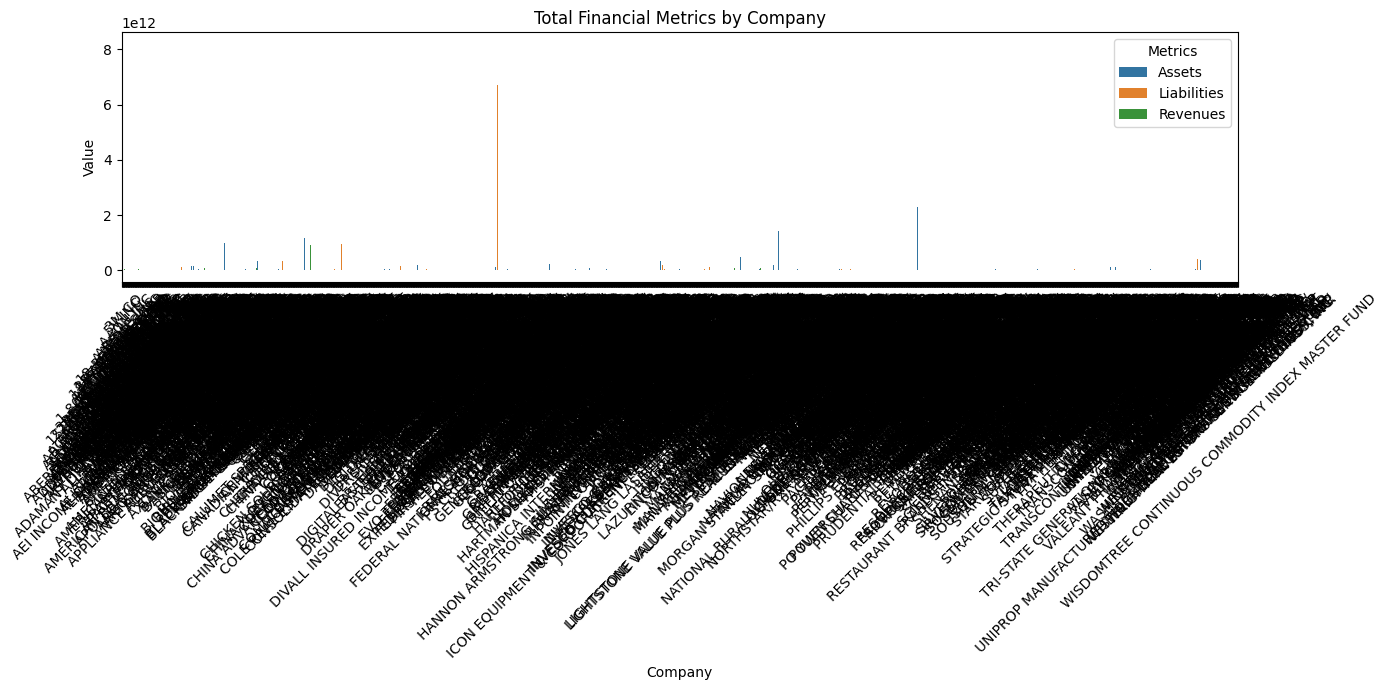

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to run a query and convert results to a list of dictionaries
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters or {})
        return [record for record in result]  # Return as a list of dictionaries

# 1. Analyze financial statements for companies
def analyze_financial_statements():
    query = """
    MATCH (c:Company)-[:REPORTS]->(m:Metric)
    RETURN c.name AS company, m.tag AS metric, m.value AS value
    ORDER BY company, metric
    """
    results = run_query(query)
    return results

# Retrieve financial statements
financial_statements = analyze_financial_statements()

# Convert to DataFrame with explicit column names
financial_statements_df = pd.DataFrame(financial_statements, columns=['company', 'metric', 'value'])

# Check the structure of the DataFrame
print("DataFrame Columns:", financial_statements_df.columns)
print("First few rows of the DataFrame:\n", financial_statements_df.head())

# Check for required columns
if 'company' not in financial_statements_df.columns or 'metric' not in financial_statements_df.columns or 'value' not in financial_statements_df.columns:
    print("The DataFrame is missing one or more required columns.")
else:
    # Create a pivot table to summarize financial metrics by company
    pivot_df = financial_statements_df.pivot_table(index='company',
                                                   columns='metric',
                                                   values='value',
                                                   aggfunc='sum').reset_index()

    # Check the pivot table
    print("Pivot Table:\n", pivot_df.head())

    # 3. Statistical Summary
    print("\nStatistical Summary of Financial Metrics:")
    print(pivot_df.describe())

    # Visualization Example: Total Financial Metrics by Company
    plt.figure(figsize=(14, 7))
    melted_df = pivot_df.melt(id_vars='company', value_vars=pivot_df.columns[1:],
                               var_name='metric', value_name='value')

    # Create a bar plot
    sns.barplot(data=melted_df, x='company', y='value', hue='metric')
    plt.title('Total Financial Metrics by Company')
    plt.xlabel('Company')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title='Metrics')
    plt.show()

# Close the Neo4j driver when done
driver.close()


###Observation.
This chart compares financial metrics (Assets, Liabilities, and Revenues) across numerous companies. The scale reaches 8 trillion, indicating some extremely large businesses. A few companies stand out with significantly higher metrics, their bars towering above the rest. For these top performers, assets typically appear largest, followed by liabilities. Most companies have much smaller metrics, resulting in barely visible bars. The dense layout with overlapping company names makes it challenging to identify specific businesses or draw detailed conclusions about individual performance.


###2nd Question

<ipython-input-100-44b470b34515>:8: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


Financial DataFrame:
                  company       metric         value
0  1 800 FLOWERS COM INC  Liabilities  2.702310e+08
1  1 800 FLOWERS COM INC  Liabilities  2.559850e+08
2  1 800 FLOWERS COM INC     Revenues  1.173024e+09
3  1 800 FLOWERS COM INC     Revenues  1.193625e+09
4  1 800 FLOWERS COM INC     Revenues  1.151921e+09
Pivot Table:
 metric                   company   Liabilities      Revenues
0          1 800 FLOWERS COM INC  5.262160e+08  3.518570e+09
1                 12 RETECH CORP  3.616559e+06  9.472100e+04
2              1847 HOLDINGS LLC  3.366558e+07  8.954218e+06
3       1ST CONSTITUTION BANCORP  2.036329e+09           NaN
4                1ST SOURCE CORP  2.146001e+10           NaN
Health Scores:
 metric                   company  Health Score
0          1 800 FLOWERS COM INC      6.686551
1                 12 RETECH CORP      0.026191
2              1847 HOLDINGS LLC      0.265975
3       1ST CONSTITUTION BANCORP           NaN
4                1ST SOURCE CORP   

<ipython-input-100-44b470b34515>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Cluster'] = kmeans.fit_predict(clean_df[['Health Score']])


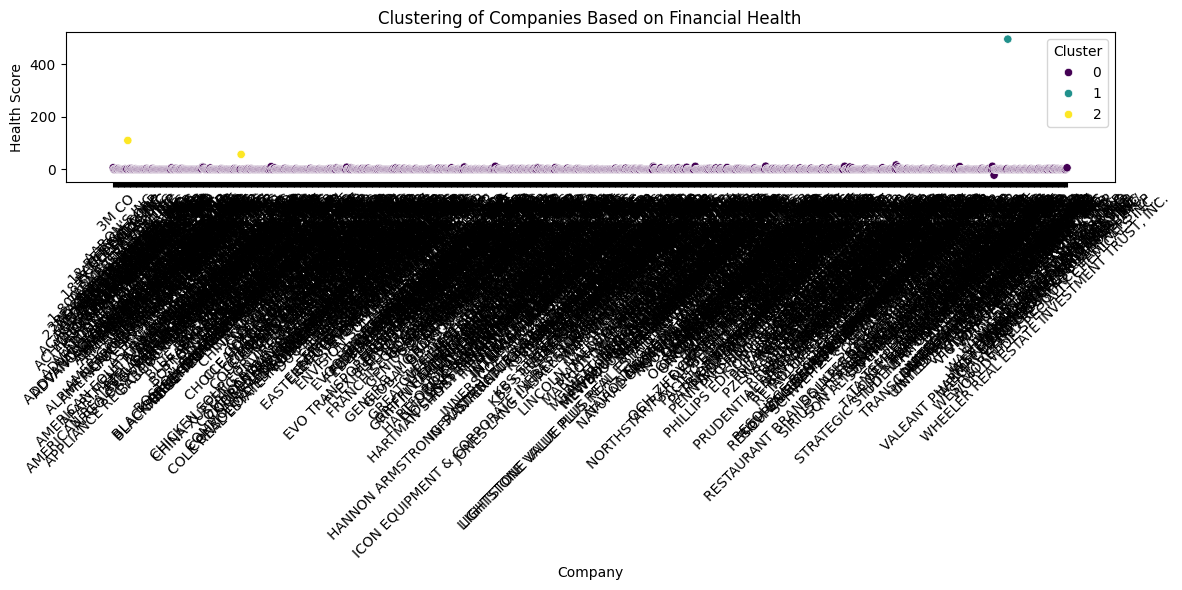

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Function to run a query and convert results to a list of dictionaries
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters or {})
        return [record for record in result]  # Return as a list of dictionaries

# 1. Retrieve Revenue and Liabilities data
def retrieve_financial_data():
    query = """
    MATCH (c:Company)-[:REPORTS]->(m:Metric)
    WHERE m.tag IN ['Revenues', 'Liabilities']
    RETURN c.name AS company, m.tag AS metric, m.value AS value
    ORDER BY company, metric
    """
    results = run_query(query)
    return results

# Get financial data
financial_data = retrieve_financial_data()

# Convert to DataFrame with explicit column names
financial_df = pd.DataFrame(financial_data, columns=['company', 'metric', 'value'])

# Check the structure of the DataFrame
print("Financial DataFrame:\n", financial_df.head())

# Pivot the DataFrame to summarize financial metrics by company
pivot_df = financial_df.pivot_table(index='company',
                                     columns='metric',
                                     values='value',
                                     aggfunc='sum').reset_index()

# Check the pivot table
print("Pivot Table:\n", pivot_df.head())

# Check if the necessary columns exist in the pivot table
if 'Liabilities' not in pivot_df.columns or 'Revenues' not in pivot_df.columns:
    print("The 'Liabilities' or 'Revenues' column is missing from the pivot table.")
else:
    # Calculate Health Score
    epsilon = 1e-10
    pivot_df['Health Score'] = pivot_df['Revenues'] / (pivot_df['Liabilities'] + epsilon)

    # Check the health scores
    print("Health Scores:\n", pivot_df[['company', 'Health Score']].head())

    # Remove rows with NaN in Health Score
    clean_df = pivot_df.dropna(subset=['Health Score'])

    # Check if any companies remain after dropping NaNs
    if clean_df.empty:
        print("No companies remain after removing NaNs in Health Score.")
    else:
        # Perform KMeans Clustering
        kmeans = KMeans(n_clusters=3)
        clean_df['Cluster'] = kmeans.fit_predict(clean_df[['Health Score']])

        # Visualize the results
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=clean_df, x='company', y='Health Score', hue='Cluster', palette='viridis')
        plt.title('Clustering of Companies Based on Financial Health')
        plt.xlabel('Company')
        plt.ylabel('Health Score')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.legend(title='Cluster')
        plt.show()

# Close the Neo4j driver when done
driver.close()


###Observation
This scatter plot shows the clustering of companies based on their financial health scores. The majority of companies are clustered together in Cluster 0 (purple) with low health scores near zero. There are two notable outliers: one company in Cluster 1 (teal) with an exceptionally high health score around 450, and two companies in Cluster 2 (yellow) with moderately high scores between 50-150. The x-axis lists numerous company names, though they're largely illegible due to overcrowding. This visualization highlights the stark contrast between a few financially robust companies and the bulk of companies with similar, lower financial health scores.

###3rd Question


<ipython-input-100-44b470b34515>:8: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


Financial DataFrame:
                  company       metric         value
0  1 800 FLOWERS COM INC  Liabilities  2.702310e+08
1  1 800 FLOWERS COM INC  Liabilities  2.559850e+08
2  1 800 FLOWERS COM INC     Revenues  1.173024e+09
3  1 800 FLOWERS COM INC     Revenues  1.193625e+09
4  1 800 FLOWERS COM INC     Revenues  1.151921e+09
Pivot Table:
 metric                   company   Liabilities      Revenues
0          1 800 FLOWERS COM INC  5.262160e+08  3.518570e+09
1                 12 RETECH CORP  3.616559e+06  9.472100e+04
2              1847 HOLDINGS LLC  3.366558e+07  8.954218e+06
3       1ST CONSTITUTION BANCORP  2.036329e+09           NaN
4                1ST SOURCE CORP  2.146001e+10           NaN
Identified Anomalies:
 metric                                           company      Revenues  \
140                     AMERICAN INTERNATIONAL GROUP INC  1.957790e+11   
191                                            APPLE INC           NaN   
238                                      

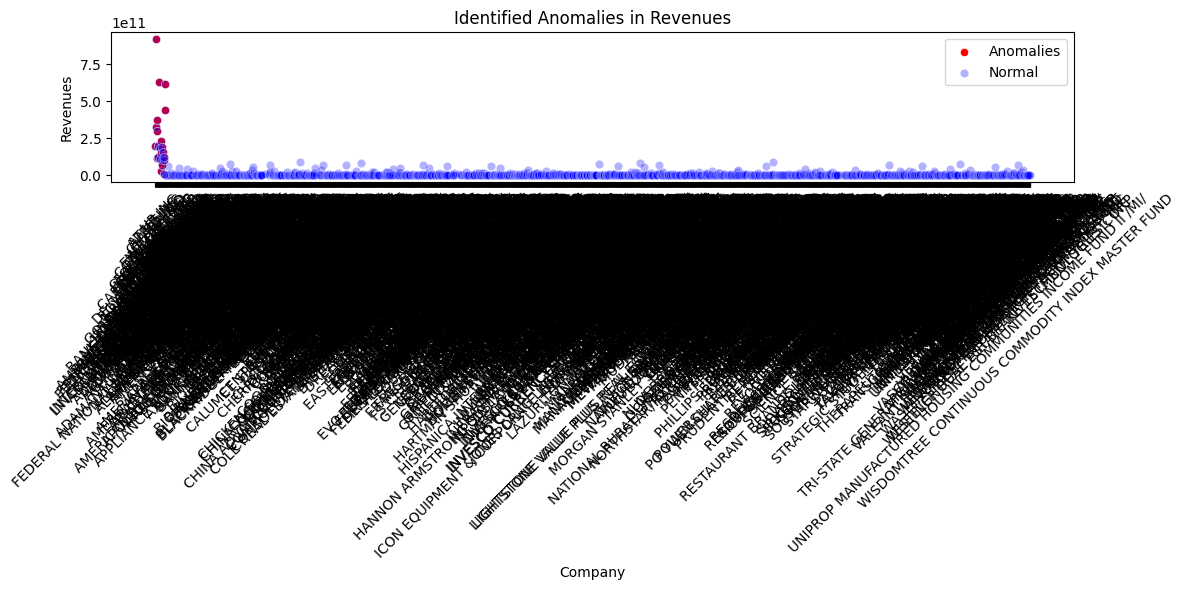

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Retrieve Financial Data
def retrieve_financial_data():
    query = """
    MATCH (c:Company)-[:REPORTS]->(m:Metric)
    WHERE m.tag IN ['Revenues', 'Liabilities']
    RETURN c.name AS company, m.tag AS metric, m.value AS value
    ORDER BY company, metric
    """
    results = run_query(query)
    return results

# Get financial data
financial_data = retrieve_financial_data()

# Convert to DataFrame with explicit column names
financial_df = pd.DataFrame(financial_data, columns=['company', 'metric', 'value'])

# Check the structure of the DataFrame
print("Financial DataFrame:\n", financial_df.head())

# Pivot the DataFrame to summarize financial metrics by company
pivot_df = financial_df.pivot_table(index='company',
                                     columns='metric',
                                     values='value',
                                     aggfunc='sum').reset_index()

# Check the pivot table
print("Pivot Table:\n", pivot_df.head())

# Calculate mean and standard deviation for each metric
stats_df = pivot_df[['company', 'Liabilities', 'Revenues']].copy()
stats_df['Revenues_mean'] = stats_df['Revenues'].mean()
stats_df['Revenues_std'] = stats_df['Revenues'].std()
stats_df['Liabilities_mean'] = stats_df['Liabilities'].mean()
stats_df['Liabilities_std'] = stats_df['Liabilities'].std()

# Identify anomalies for Revenues
threshold = 2  # Define threshold for anomaly detection
pivot_df['Revenues_anomaly'] = (
    (pivot_df['Revenues'] - stats_df['Revenues_mean']) > (threshold * stats_df['Revenues_std'])
)

# Identify anomalies for Liabilities
pivot_df['Liabilities_anomaly'] = (
    (pivot_df['Liabilities'] - stats_df['Liabilities_mean']) > (threshold * stats_df['Liabilities_std'])
)

# Combine the anomaly results
pivot_df['anomaly'] = pivot_df[['Revenues_anomaly', 'Liabilities_anomaly']].any(axis=1)

# Check identified anomalies
anomalies = pivot_df[pivot_df['anomaly']]
print("Identified Anomalies:\n", anomalies[['company', 'Revenues', 'Liabilities']])

# Visualization of anomalies
plt.figure(figsize=(12, 6))
sns.scatterplot(data=pivot_df[pivot_df['anomaly']],
                 x='company',
                 y='Revenues',
                 color='red',
                 label='Anomalies')
sns.scatterplot(data=pivot_df,
                 x='company',
                 y='Revenues',
                 color='blue',
                 alpha=0.3,
                 label='Normal')

plt.title('Identified Anomalies in Revenues')
plt.xlabel('Company')
plt.ylabel('Revenues')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Close the Neo4j driver when done
driver.close()


###Observation
This scatter plot displays identified anomalies in company revenues. Most companies' revenues (blue dots) cluster near zero, forming a dense horizontal band. A small group of companies, marked as anomalies (red dots), show significantly higher revenues, with values ranging from about 2.5 to 9 on a scale of 10^11. These outliers are concentrated on the left side of the chart, suggesting they may be related to specific industries or company types. The x-axis lists numerous company names, but they're largely unreadable due to overcrowding. This visualization effectively highlights the stark contrast between a few high-revenue outliers and the majority of companies with more typical revenue figures.

###4th Question

Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: ChangesInReservesRecoverableFromInsurance, Value: 2400000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: ProceedsFromRepaymentOfLoan, Value: 0.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount, Value: 415000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: InterestIncomeExpenseNet, Value: -42500000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: DepreciationAmortizationAndAssetImpairmentCharges, Value: 58400000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: SalesRevenueNet, Value: 1475500000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: OperatingLeasesFutureMinimumPaymentsDueThereafter, Value: 50200000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment, Value: 510400000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: Other

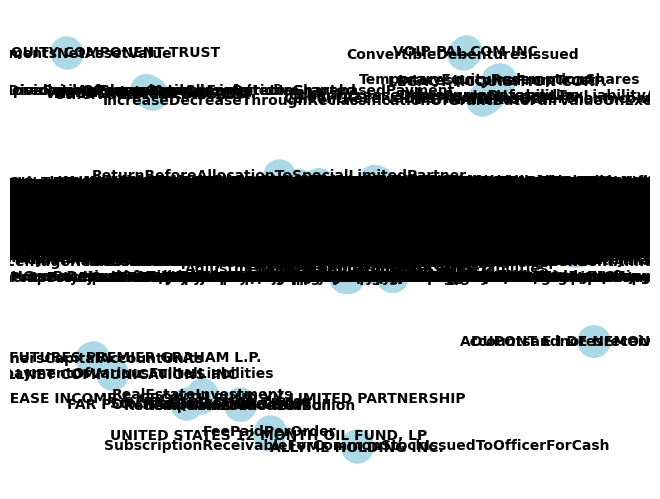

In [ ]:
from neo4j import GraphDatabase
import pandas as pd
import requests
from bs4 import BeautifulSoup
import concurrent.futures
import networkx as nx
import matplotlib.pyplot as plt


# Function to run Neo4j queries
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters or {})
        return list(result)

# Step 1: Fetch company metrics data
def fetch_company_metrics():
    query = """
    MATCH (c:Company)-[:HAS_METRIC]->(m:Metric)
    RETURN c.name AS company, c.cik AS cik, m.tag AS metric_tag, m.value AS metric_value
    LIMIT 100
    """
    return run_query(query)

# Step 2: Scrape SEC URLs for executive data
def fetch_office_holder_data(cik):
    url = f"https://www.sec.gov/Archives/edgar/data/{cik}/"
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    target_text = "this report has been signed below by the following persons on behalf of the Registrant"
    table = None
    for tag in soup.find_all(True):
        if target_text.lower() in ' '.join(tag.get_text().split()).lower():
            table = tag.find_next('table')

    if table:
        s_tags = table.find_all(string=lambda text: text.startswith('/s/'))
        return [s_tag.strip()[3:].strip() for s_tag in s_tags]
    return []

# Step 3: Insert executive data into Neo4j
def insert_executives_to_neo4j(executive_data):
    query = """
    UNWIND $executive_data AS row
    MERGE (c:Company {cik: row.cik})
    MERGE (e:Executive {name: row.exec_name})
    MERGE (e)-[:HOLDS_TITLE]->(c)
    """
    run_query(query, {"executive_data": executive_data})

# Step 4: Process filings to extract executive names and insert them into Neo4j
def process_filings_for_executives():
    metrics = fetch_company_metrics()
    executive_data = []

    for record in metrics:
        cik = record['cik']
        executive_names = fetch_office_holder_data(cik)
        for name in executive_names:
            executive_data.append({"exec_name": name, "cik": cik})

    if executive_data:
        insert_executives_to_neo4j(executive_data)

# Step 5: Analyze connections using available relationships
def analyze_connections():
    query = """
    MATCH (c:Company)-[:HAS_METRIC]->(m:Metric)
    RETURN c.name AS Company, c.cik AS cik, m.tag AS metric_tag, m.value AS metric_value
    LIMIT 100
    """
    result = run_query(query)
    for record in result:
        print(f"Company: {record['Company']}, CIK: {record['cik']}, Metric Tag: {record['metric_tag']}, Value: {record['metric_value']}")

# Step 6: Visualize connections
def visualize_connections():
    query = """
    MATCH (c:Company)-[:HAS_METRIC]->(m:Metric)
    RETURN c.name AS Company, m.tag AS metric_tag
    """
    results = run_query(query)
    connections = [(record["Company"], record["metric_tag"]) for record in results]

    G = nx.Graph()
    for company_name, metric_tag in connections:
        G.add_node(company_name, label="Company")
        G.add_node(metric_tag, label="Metric Tag")
        G.add_edge(company_name, metric_tag)

    if len(G.nodes) == 0:
        print("No nodes to layout")
        return

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=10, font_weight="bold")
    plt.show()

# Main Execution Flow
process_filings_for_executives()  # Fetch and process executive data
analyze_connections()               # Analyze connections based on existing data
visualize_connections()             # Visualize the network

# Close the Neo4j driver connection
driver.close()


Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: ChangesInReservesRecoverableFromInsurance, Value: 2400000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: ProceedsFromRepaymentOfLoan, Value: 0.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount, Value: 415000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: InterestIncomeExpenseNet, Value: -42500000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: DepreciationAmortizationAndAssetImpairmentCharges, Value: 58400000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: SalesRevenueNet, Value: 1475500000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: OperatingLeasesFutureMinimumPaymentsDueThereafter, Value: 50200000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment, Value: 510400000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: Other

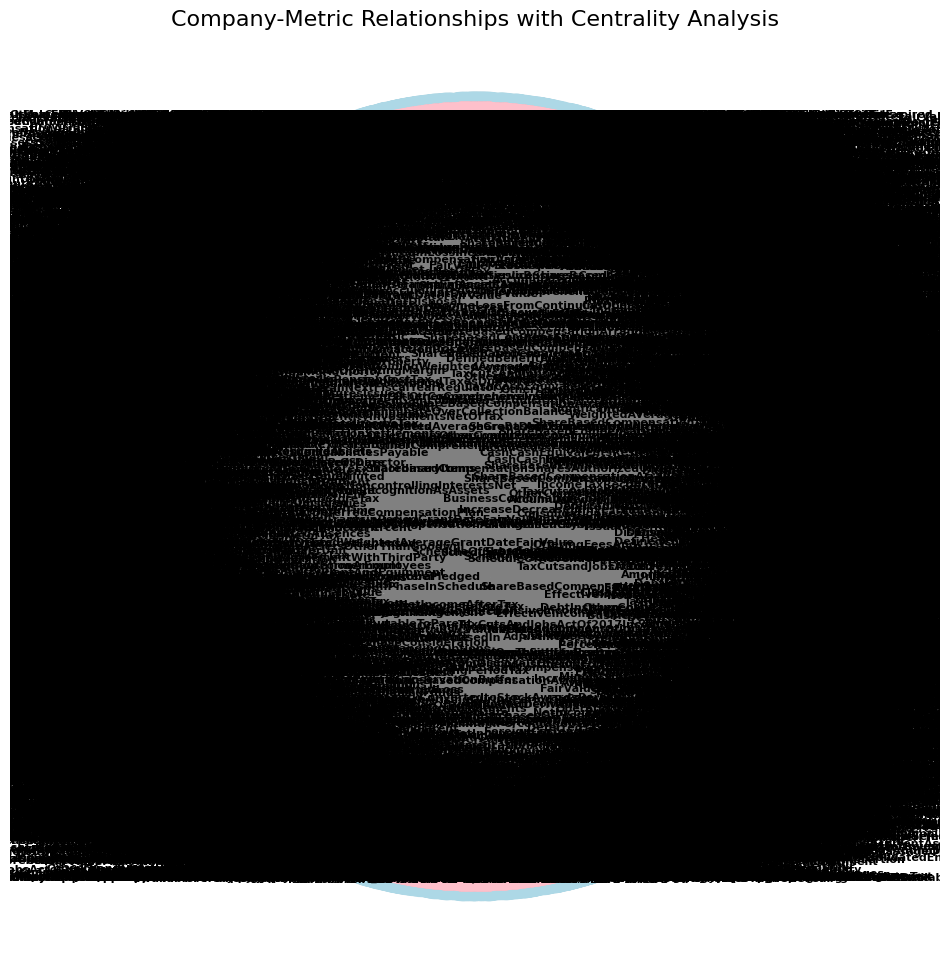

In [ ]:
from neo4j import GraphDatabase
import pandas as pd
import requests
from bs4 import BeautifulSoup
import concurrent.futures
import networkx as nx
import matplotlib.pyplot as plt


# Function to run Neo4j queries
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters or {})
        return list(result)

# Step 1: Fetch company metrics data
def fetch_company_metrics():
    query = """
    MATCH (c:Company)-[:HAS_METRIC]->(m:Metric)
    RETURN c.name AS company, c.cik AS cik, m.tag AS metric_tag, m.value AS metric_value
    LIMIT 100
    """
    return run_query(query)

# Step 6: Visualize connections in a circular layout
def visualize_connections():
    query = """
    MATCH (c:Company)-[:HAS_METRIC]->(m:Metric)
    RETURN c.name AS Company, m.tag AS metric_tag
    """
    results = run_query(query)
    connections = [(record["Company"], record["metric_tag"]) for record in results]

    G = nx.Graph()
    for company_name, metric_tag in connections:
        G.add_node(company_name, label="Company")
        G.add_node(metric_tag, label="Metric Tag")
        G.add_edge(company_name, metric_tag)

    if len(G.nodes) == 0:
        print("No nodes to layout")
        return

    # Customize node sizes
    node_size_map = [1000 if "Company" in node else 300 for node in G.nodes()]

    # Circular layout to mimic the structure in your image
    pos = nx.circular_layout(G)

    # Draw nodes with color differentiation (Companies in one color, Metrics in another)
    company_nodes = [node for node, attr in G.nodes(data=True) if attr['label'] == "Company"]
    metric_nodes = [node for node, attr in G.nodes(data=True) if attr['label'] == "Metric Tag"]

    plt.figure(figsize=(12, 12))

    # Draw company nodes (in light blue)
    nx.draw_networkx_nodes(G, pos, nodelist=company_nodes, node_size=1000, node_color='lightblue', alpha=0.9)

    # Draw metric nodes (in pink)
    nx.draw_networkx_nodes(G, pos, nodelist=metric_nodes, node_size=300, node_color='pink', alpha=0.8)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.0, alpha=0.5)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black', font_weight='bold')

    plt.title("Company-Metric Relationships with Centrality Analysis", fontsize=16)
    plt.axis('off')
    plt.show()

# Main Execution Flow
process_filings_for_executives()  # Fetch and process executive data
analyze_connections()               # Analyze connections based on existing data
visualize_connections()             # Visualize the network

# Close the Neo4j driver connection
driver.close()


###Observation
"Company-Metric Relationships with Centrality Analysis". It features:

A circular layout with numerous nodes and connections.
Text labels around the perimeter, representing various financial metrics and business terms (e.g., "TotalContinuingOperatingRevenue", "AverageNumberEmployees").
A dense web of light-colored lines in the center, connecting different nodes.
Varying node sizes, likely indicating different levels of importance or centrality in the network.
A black background with light-colored (possibly white or light blue) text and connections.
Two semicircular arcs at the bottom of the image, one light blue and one pink, possibly representing additional categorization or grouping.

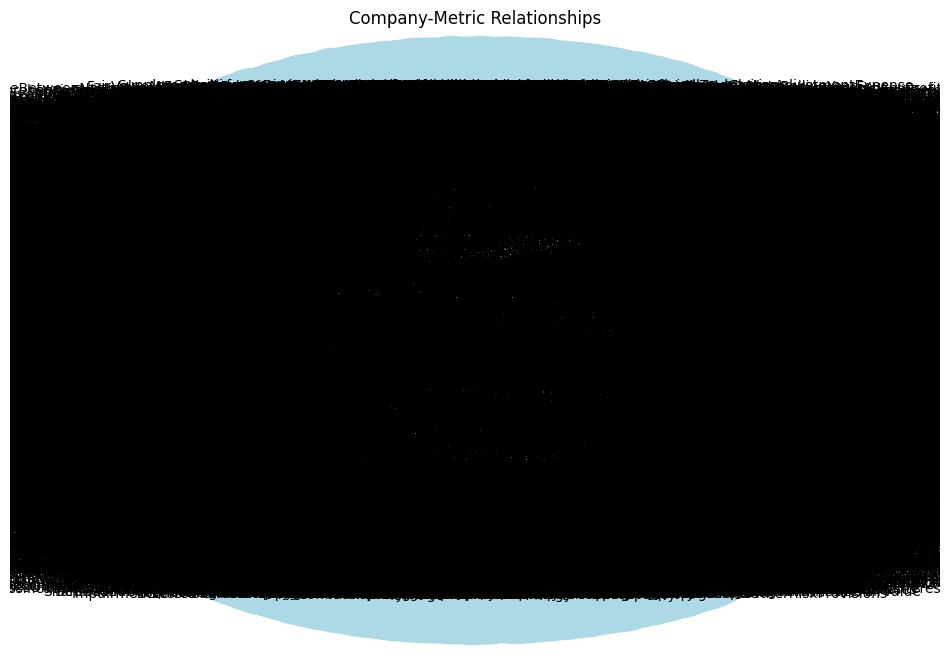

In [ ]:
from neo4j import GraphDatabase
import pandas as pd
import requests
from bs4 import BeautifulSoup
import concurrent.futures
import networkx as nx
import matplotlib.pyplot as plt


# Function to run Neo4j queries
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters or {})
        return list(result)

# Step 1: Fetch company metrics data
def fetch_company_metrics():
    query = """
    MATCH (c:Company)-[:HAS_METRIC]->(m:Metric)
    RETURN c.name AS company, c.cik AS cik, m.tag AS metric_tag, m.value AS metric_value
    LIMIT 100
    """
    return run_query(query)

# Step 2: Visualize connections
def visualize_connections():
    query = """
    MATCH (c:Company)-[:HAS_METRIC]->(m:Metric)
    RETURN c.name AS Company, m.tag AS metric_tag
    """
    results = run_query(query)

    # Create a graph structure
    G = nx.Graph()

    for record in results:
        company_name = record['Company']
        metric_tag = record['metric_tag']

        # Add nodes and edges
        G.add_node(company_name, label="Company")
        G.add_node(metric_tag, label="Metric Tag")
        G.add_edge(company_name, metric_tag)

    # Draw the graph
    plt.figure(figsize=(12, 8))

    pos = nx.spring_layout(G, k=0.5, iterations=50)  # Adjust the layout parameters
    nx.draw_networkx_nodes(G, pos, node_size=5000, node_color='lightblue', alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    # Labels for the nodes
    labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10)

    plt.title("Company-Metric Relationships")
    plt.axis('off')  # Turn off the axis
    plt.show()

# Main Execution Flow
visualize_connections()  # Visualize the network

# Close the Neo4j driver connection
driver.close()


<ipython-input-13-816d639adaf2>:17: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: ChangesInReservesRecoverableFromInsurance, Value: 2400000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: ProceedsFromRepaymentOfLoan, Value: 0.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount, Value: 415000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: InterestIncomeExpenseNet, Value: -42500000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: DepreciationAmortizationAndAssetImpairmentCharges, Value: 58400000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: SalesRevenueNet, Value: 1475500000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: OperatingLeasesFutureMinimumPaymentsDueThereafter, Value: 50200000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment, Value: 510400000.0
Company: KOPPERS HOLDINGS INC., CIK: None, Metric Tag: Other

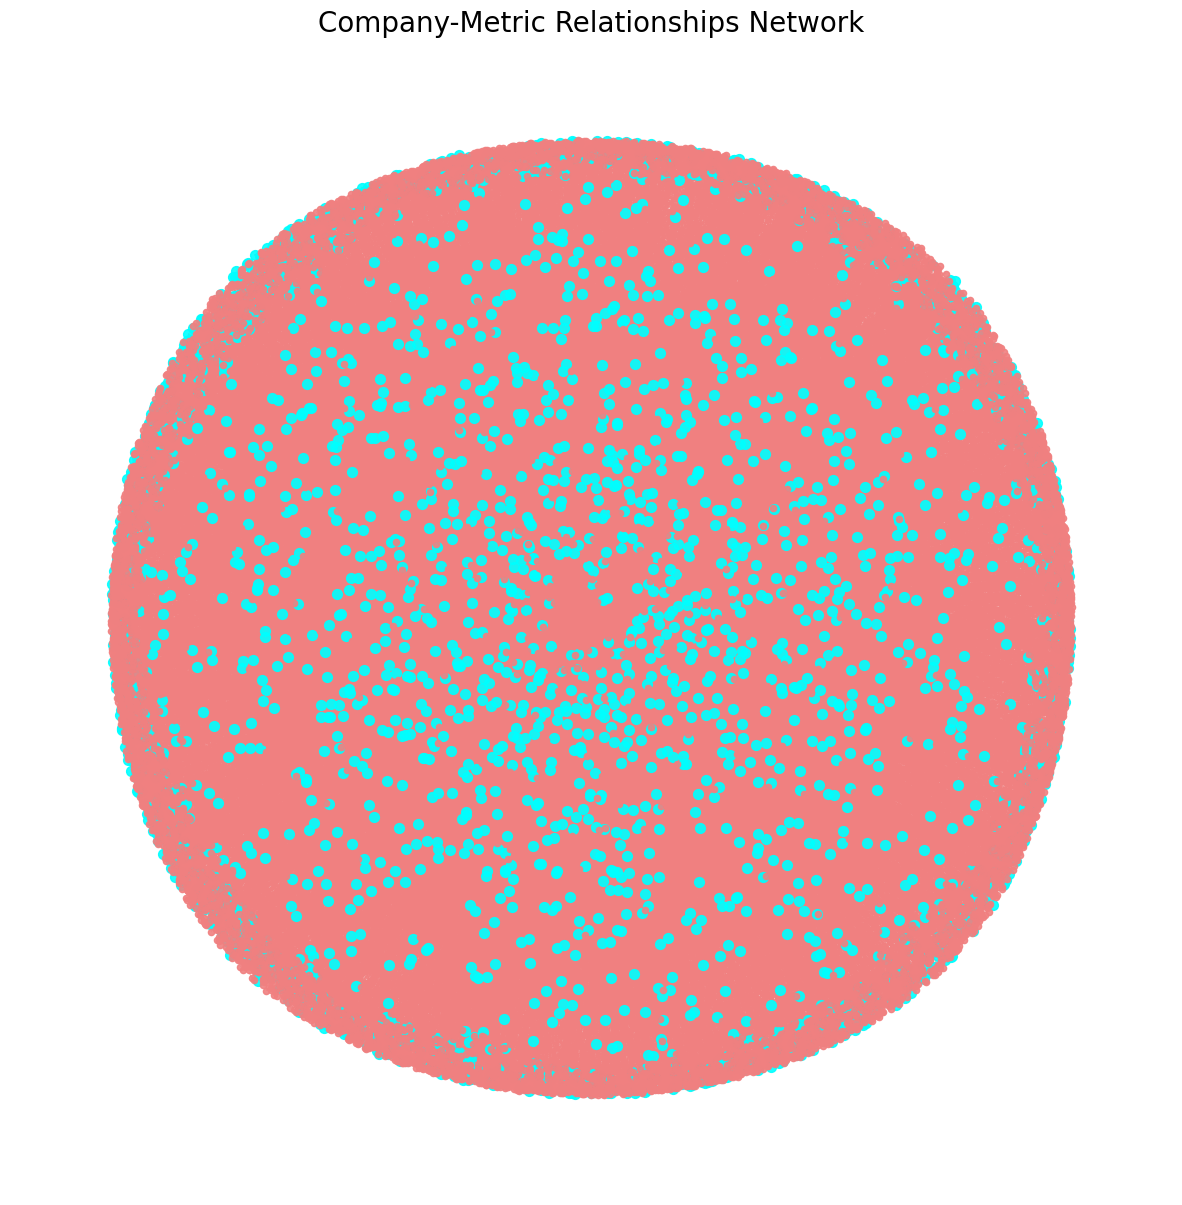

In [ ]:
# Step 6: Visualize connections in a similar style to the shared image
def visualize_connections():
    query = """
    MATCH (c:Company)-[:HAS_METRIC]->(m:Metric)
    RETURN c.name AS Company, m.tag AS metric_tag
    """
    results = run_query(query)
    connections = [(record["Company"], record["metric_tag"]) for record in results]

    G = nx.Graph()
    for company_name, metric_tag in connections:
        G.add_node(company_name, label="Company")
        G.add_node(metric_tag, label="Metric Tag")
        G.add_edge(company_name, metric_tag)

    if len(G.nodes) == 0:
        print("No nodes to layout")
        return

    plt.figure(figsize=(15, 15))  # Larger figure for better visual separation

    # Use spring layout for better node spacing
    pos = nx.spring_layout(G, k=0.7, iterations=100)  # k adjusts spacing, more iterations for better convergence

    # Draw company nodes in cyan
    nx.draw_networkx_nodes(G, pos, nodelist=[node for node, attr in G.nodes(data=True) if attr['label'] == "Company"],
                           node_size=50, node_color='cyan', alpha=0.9)

    # Draw metric nodes in light pink
    nx.draw_networkx_nodes(G, pos, nodelist=[node for node, attr in G.nodes(data=True) if attr['label'] == "Metric Tag"],
                           node_size=20, node_color='lightcoral', alpha=0.9)

    # Draw edges with light red for clear contrast
    nx.draw_networkx_edges(G, pos, edge_color='lightcoral', width=0.7, alpha=0.6)

    # Turn off the labels for a clean visualization
    # Note: no call to nx.draw_networkx_labels()

    # Remove axes for a cleaner look
    plt.title("Company-Metric Relationships Network", fontsize=20)
    plt.axis('off')  # Turn off the axes for a clean look
    plt.show()

# Main Execution Flow
process_filings_for_executives()  # Fetch and process executive data
analyze_connections()               # Analyze connections based on existing data
visualize_connections()             # Visualize the network in a spring layout

# Close the Neo4j driver connection
driver.close()


###Observation
Company-Metric Relationships Network". It consists of numerous cyan nodes scattered across a pink background, forming a dense interconnected web. The nodes likely represent companies or financial metrics, with the connections between them indicating relationships or correlations. The diagram suggests a complex, highly interconnected system of financial relationships among multiple entities.

Degree Centrality: {'KOPPERS HOLDINGS INC.': 0.2588235294117647, 'ChangesInReservesRecoverableFromInsurance': 0.011764705882352941, 'ProceedsFromRepaymentOfLoan': 0.011764705882352941, 'AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount': 0.011764705882352941, 'InterestIncomeExpenseNet': 0.011764705882352941, 'DepreciationAmortizationAndAssetImpairmentCharges': 0.011764705882352941, 'SalesRevenueNet': 0.011764705882352941, 'OperatingLeasesFutureMinimumPaymentsDueThereafter': 0.011764705882352941, 'AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment': 0.011764705882352941, 'OtherComprehensiveIncomeLossPensionAndOtherPostretirementBenefitPlansBenefitPlanImprovementTaxEffect': 0.011764705882352941, 'SelfInsuranceReserve': 0.011764705882352941, 'ReceivablesNetCurrent': 0.011764705882352941, 'OperatingIncomeLoss': 0.03529411764705882, 'LongTermDebtNoncurrent': 0.011764705882352941, 'DeferredRevenue': 0.011764705882352941, 'OtherComprehensiveIncomeLoss

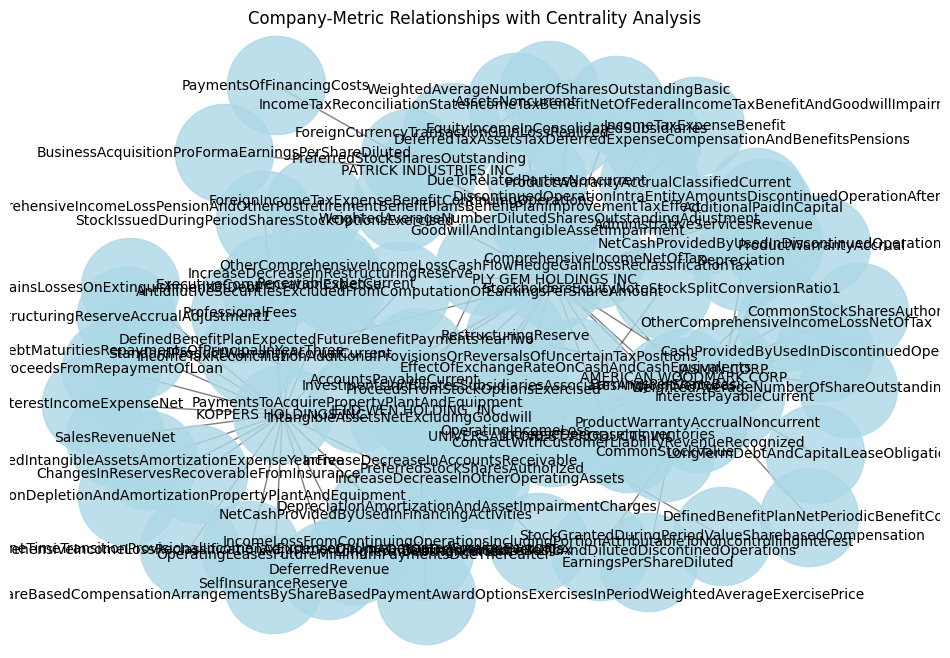

In [ ]:
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt



# Function to run Neo4j queries
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters or {})
        return list(result)

# Step 1: Fetch company metrics data
def fetch_company_metrics():
    query = """
    MATCH (c:Company)-[:HAS_METRIC]->(m:Metric)
    RETURN c.name AS company, m.tag AS metric_tag
    LIMIT 100
    """
    return run_query(query)

# Step 2: Visualize connections and centrality
def visualize_connections_with_centrality():
    results = fetch_company_metrics()

    G = nx.Graph()

    for record in results:
        company_name = record['company']
        metric_tag = record['metric_tag']

        # Add nodes and edges
        G.add_node(company_name, label="Company")
        G.add_node(metric_tag, label="Metric Tag")
        G.add_edge(company_name, metric_tag)

    # Calculate centrality measures
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    # Print centrality values
    print("Degree Centrality:", degree_centrality)
    print("Closeness Centrality:", closeness_centrality)
    print("Betweenness Centrality:", betweenness_centrality)

    # Draw the graph
    plt.figure(figsize=(12, 8))

    pos = nx.spring_layout(G, k=0.5, iterations=50)
    nx.draw_networkx_nodes(G, pos, node_size=5000, node_color='lightblue', alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    # Labels for the nodes
    labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10)

    plt.title("Company-Metric Relationships with Centrality Analysis")
    plt.axis('off')
    plt.show()

# Main Execution Flow
visualize_connections_with_centrality()  # Visualize the network with centrality

# Close the Neo4j driver connection
driver.close()


In [ ]:
!pip install transformers spacy


###5th question


In [ ]:
import re
import sys
from neo4j import GraphDatabase



# Function to run Neo4j queries
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters or {})
        return list(result)

# Function to handle predefined queries
def handle_predefined_query(choice):
    if choice == '1':
        # Show total revenues for all companies
        query = """
        MATCH (c:Company)-[:REPORTS]->(m:Metric)
        WHERE m.tag = 'Revenues'
        RETURN c.name AS Company, SUM(m.value) AS TotalRevenue
        ORDER BY TotalRevenue DESC
        """
        results = run_query(query)
        if results:
            for record in results:
                print(f"Company: {record['Company']}, Total Revenue: {record['TotalRevenue']:.2f}")
        else:
            print("No revenue records found for any company.")

    elif choice == '2':
        # Show total assets for a specific company
        company_name = input("Enter the company name: ").strip().title()
        query = f"""
        MATCH (c:Company {{name: '{company_name}'}})-[:REPORTS]->(m:Metric)
        WHERE m.tag = 'Assets'
        RETURN c.name AS Company, SUM(m.value) AS TotalAssets
        """
        results = run_query(query)
        if results:
            for record in results:
                print(f"Company: {record['Company']}, Total Assets: {record['TotalAssets']:.2f}")
        else:
            print(f"No asset records found for {company_name}.")

    elif choice == '3':
        # Show liabilities for a specific company
        company_name = input("Enter the company name: ").strip().title()
        query = f"""
        MATCH (c:Company {{name: '{company_name}'}})-[:REPORTS]->(m:Metric)
        WHERE m.tag = 'Liabilities'
        RETURN c.name AS Company, SUM(m.value) AS TotalLiabilities
        """
        results = run_query(query)
        if results:
            for record in results:
                print(f"Company: {record['Company']}, Total Liabilities: {record['TotalLiabilities']:.2f}")
        else:
            print(f"No liability records found for {company_name}.")

    elif choice == '4':
        # Show executives of a specific company
        company_name = input("Enter the company name: ").strip().title()
        query = f"""
        MATCH (e:Executive)-[:HOLDS_TITLE]->(c:Company {{name: '{company_name}'}})
        RETURN e.name AS ExecutiveName
        """
        results = run_query(query)
        if results:
            for record in results:
                print(f"Executive: {record['ExecutiveName']}")
        else:
            print(f"No executives found for {company_name}.")

    elif choice == '5':
        # Ask your own query
        user_query = input("Enter your financial query (e.g., 'Show total revenue for KOPPERS HOLDINGS INC.'): ")
        cypher_query = transform_query(user_query)
        if cypher_query:
            print(f"Executing query: {cypher_query}")  # Debugging line
            results = run_query(cypher_query)
            if results:
                for record in results:
                    print(record)  # Print the results as they come
            else:
                print("No records found for your query.")
        else:
            print("Could not understand your query. Please try again.")

    elif choice == '6':
        print("Exiting the program.")
        driver.close()  # Close the database connection
        sys.exit()  # Exit the program using sys.exit()

# Function to transform user queries into Cypher queries
def transform_query(user_input):
    user_input = user_input.lower().strip()

    # Check for revenue queries
    revenue_patterns = [
        r"show total revenue for (.+)",
        r"give me revenue for (.+)",
        r"what is the revenue of (.+)",
        r"top (\d+) revenue companies",
        r"show top (\d+) companies in revenue",
        r"top (\d+) companies"  # Added to match top companies
    ]

    for pattern in revenue_patterns:
        match = re.match(pattern, user_input)
        if match:
            if match.group(0).startswith("top"):
                return f"""
                MATCH (c:Company)-[:REPORTS]->(m:Metric)
                WHERE m.tag = 'Revenues'
                RETURN c.name AS Company, SUM(m.value) AS TotalRevenue
                ORDER BY TotalRevenue DESC
                LIMIT {match.group(1)}
                """
            else:
                company_name = match.group(1).strip().title()  # Extract the company name
                return f"""
                MATCH (c:Company {{name: '{company_name}'}})-[:REPORTS]->(m:Metric)
                WHERE m.tag = 'Revenues'
                RETURN c.name AS Company, SUM(m.value) AS TotalRevenue
                """

    # Check for total assets
    assets_patterns = [
        r"show total assets for (.+)",
        r"give me assets for (.+)",
        r"what are the assets of (.+)"
    ]

    for pattern in assets_patterns:
        match = re.match(pattern, user_input)
        if match:
            company_name = match.group(1).strip().title()  # Extract the company name
            return f"""
            MATCH (c:Company {{name: '{company_name}'}})-[:REPORTS]->(m:Metric)
            WHERE m.tag = 'Assets'
            RETURN c.name AS Company, SUM(m.value) AS TotalAssets
            """

    # Check for liabilities
    liabilities_patterns = [
        r"show liabilities for (.+)",
        r"give me liabilities for (.+)",
        r"what are the liabilities of (.+)"
    ]

    for pattern in liabilities_patterns:
        match = re.match(pattern, user_input)
        if match:
            company_name = match.group(1).strip().title()  # Extract the company name
            return f"""
            MATCH (c:Company {{name: '{company_name}'}})-[:REPORTS]->(m:Metric)
            WHERE m.tag = 'Liabilities'
            RETURN c.name AS Company, SUM(m.value) AS TotalLiabilities
            """

    # Check for executives
    executives_patterns = [
        r"show executives of (.+)",
        r"give me executives for (.+)",
        r"who are the executives of (.+)"
    ]

    for pattern in executives_patterns:
        match = re.match(pattern, user_input)
        if match:
            company_name = match.group(1).strip().title()  # Extract the company name
            return f"""
            MATCH (e:Executive)-[:HOLDS_TITLE]->(c:Company {{name: '{company_name}'}})
            RETURN e.name AS ExecutiveName
            """

    return None  # If the query cannot be transformed

# Main loop to handle user interaction
while True:
    print("\nDefault Financial Analysis Options:")
    print("1. Show total revenues for all companies.")
    print("2. Show total assets for a specific company.")
    print("3. Show liabilities for a specific company.")
    print("4. Show executives of a specific company.")
    print("5. Ask your own query.")
    print("6. Exit")
    user_choice = input("Please select an option (1-6): ")

    if user_choice in ['1', '2', '3', '4', '5', '6']:
        handle_predefined_query(user_choice)
    else:
        print("Invalid choice. Please select a valid option.")



Default Financial Analysis Options:
1. Show total revenues for all companies.
2. Show total assets for a specific company.
3. Show liabilities for a specific company.
4. Show executives of a specific company.
5. Ask your own query.
6. Exit
Please select an option (1-6): 5
Enter your financial query (e.g., 'Show total revenue for KOPPERS HOLDINGS INC.'): Top 5 companies with the highest total assets and their executives.
Executing query: 
                MATCH (c:Company)-[:REPORTS]->(m:Metric)
                WHERE m.tag = 'Revenues'
                RETURN c.name AS Company, SUM(m.value) AS TotalRevenue
                ORDER BY TotalRevenue DESC
                LIMIT 5
                
<Record Company='CARDINAL HEALTH INC' TotalRevenue=919040000000.0>
<Record Company='FORD MOTOR CO' TotalRevenue=627868000000.0>
<Record Company='WALGREENS BOOTS ALLIANCE, INC.' TotalRevenue=616853000000.0>
<Record Company='VERIZON COMMUNICATIONS INC' TotalRevenue=440073000000.0>
<Record Company='CVS HEA

SystemExit: 

###Further analysis

In [ ]:
# Assuming you have already established your Neo4j connection as `driver`

# 1. Analyze financial statements for companies
def analyze_financial_statements():
    query = """
    MATCH (c:Company)-[:REPORTS]->(m:Metric)
    RETURN c.name AS company, m.tag AS metric, m.value AS value
    ORDER BY company, metric
    """
    results = run_query(query)
    return results

# 2. Cluster companies based on financial health
def cluster_companies():
    query = """
    MATCH (c:Company)-[:REPORTS]->(m:Metric)
    WHERE m.tag IN ['Assets', 'Liabilities', 'Revenues']
    RETURN c.name AS company,
           SUM(CASE WHEN m.tag = 'Assets' THEN m.value ELSE 0 END) AS total_assets,
           SUM(CASE WHEN m.tag = 'Liabilities' THEN m.value ELSE 0 END) AS total_liabilities,
           SUM(CASE WHEN m.tag = 'Revenues' THEN m.value ELSE 0 END) AS total_revenues
    """
    results = run_query(query)
    return results

# 3. Identify unusual financial patterns
def identify_unusual_patterns(threshold):
    query = """
    MATCH (c:Company)-[:REPORTS]->(m:Metric)
    WHERE m.value > $threshold
    RETURN c.name AS company, m.tag AS metric, m.value AS value
    """
    results = run_query(query, {"threshold": threshold})  # Use the threshold parameter
    return results

# 4. Analyze connections among executives
def analyze_executive_connections():
    query = """
    MATCH (e:Executive)-[:SITS_ON]->(c:Company)
    RETURN e.name AS executive, COLLECT(c.name) AS companies
    """
    results = run_query(query)
    return results

# 5. Financial Query and Report Generation
def financial_query(desired_metric):
    query = """
    MATCH (c:Company)-[:REPORTS]->(m:Metric)
    WHERE m.tag = $desired_metric
    RETURN c.name AS company, m.value AS value
    """
    results = run_query(query, {"desired_metric": desired_metric})  # Use the desired_metric parameter
    return results

# Set your desired threshold for unusual patterns
threshold_value = 1000000  # Adjust this value as needed

# Run your analyses and print the results
financial_statements = analyze_financial_statements()
print(financial_statements)

financial_health_df = cluster_companies()
print(financial_health_df)

# Call the function with the threshold
unusual_patterns = identify_unusual_patterns(threshold_value)
print(unusual_patterns)

executive_connections = analyze_executive_connections()
print(executive_connections)

# Replace 'desired_metric' with the actual metric you want to query
desired_metric = 'Revenues'  # Example metric, change as needed
financial_query_results = financial_query(desired_metric)
print(financial_query_results)

# Make sure to close the Neo4j driver at the end
driver.close()


[<Record company='1 800 FLOWERS COM INC' metric='Assets' value=552470000.0>, <Record company='1 800 FLOWERS COM INC' metric='Assets' value=570889000.0>, <Record company='1 800 FLOWERS COM INC' metric='Liabilities' value=270231000.0>, <Record company='1 800 FLOWERS COM INC' metric='Liabilities' value=255985000.0>, <Record company='1 800 FLOWERS COM INC' metric='Revenues' value=1173024000.0>, <Record company='1 800 FLOWERS COM INC' metric='Revenues' value=1193625000.0>, <Record company='1 800 FLOWERS COM INC' metric='Revenues' value=1151921000.0>, <Record company='12 RETECH CORP' metric='Assets' value=523927.0>, <Record company='12 RETECH CORP' metric='Assets' value=132486.0>, <Record company='12 RETECH CORP' metric='Liabilities' value=2433282.0>, <Record company='12 RETECH CORP' metric='Liabilities' value=1183277.0>, <Record company='12 RETECH CORP' metric='Revenues' value=25624.0>, <Record company='12 RETECH CORP' metric='Revenues' value=16682.0>, <Record company='12 RETECH CORP' metri

[<Record company='TEXAS PACIFIC LAND TRUST' metric='Assets' value=219701000.0>, <Record company='TEXAS PACIFIC LAND TRUST' metric='Assets' value=120035000.0>, <Record company='TEXAS PACIFIC LAND TRUST' metric='Liabilities' value=14937000.0>, <Record company='TEXAS PACIFIC LAND TRUST' metric='Liabilities' value=24661000.0>, <Record company='TEXAS PACIFIC LAND TRUST' metric='Revenues' value=51977000.0>, <Record company='TEXAS PACIFIC LAND TRUST' metric='Revenues' value=114677000.0>, <Record company='TEXAS PACIFIC LAND TRUST' metric='Revenues' value=73168000.0>, <Record company='TEXAS PACIFIC LAND TRUST' metric='Revenues' value=207019000.0>, <Record company='SPECTRUM BRANDS HOLDINGS, INC.' metric='Assets' value=7419700000.0>, <Record company='SPECTRUM BRANDS HOLDINGS, INC.' metric='Assets' value=7576800000.0>, <Record company='SPECTRUM BRANDS HOLDINGS, INC.' metric='Assets' value=7403900000.0>, <Record company='SPECTRUM BRANDS HOLDINGS, INC.' metric='Assets' value=7589200000.0>, <Record c

In [ ]:
# Fixing the SettingWithCopyWarning using .loc[]
num.loc[:, 'value'] = pd.to_numeric(num['value'], errors='coerce')


In [ ]:
# Check for any missing values in critical columns
print("Missing values in critical columns (sub):")
print(sub.isnull().sum())

print("Missing values in critical columns (num):")
print(num.isnull().sum())

# Check for duplicate records
print(f"Number of duplicate records in merged_data: {merged_data.duplicated().sum()}")

# Ensure financial values (num['value']) are numeric and without NaNs
num['value'] = pd.to_numeric(num['value'], errors='coerce')
print(f"Number of NaN values in financial data: {num['value'].isna().sum()}")

# Check for unique 'adsh' values to ensure each company is uniquely identified
print(f"Number of unique 'adsh' values: {merged_data['adsh'].nunique()}")


Missing values in critical columns (sub):
adsh            0
cik             0
name            0
sic            19
countryba      53
stprba       2542
cityba         54
zipba          71
fy            482
fp            567
period          0
dtype: int64
Missing values in critical columns (num):
adsh     0
tag      0
ddate    0
value    0
dtype: int64
Number of duplicate records in merged_data: 588
Number of NaN values in financial data: 0
Number of unique 'adsh' values: 26108


In [ ]:
# Preview the cleaned and merged data
print("Preview of the cleaned data to be loaded into Neo4j:")
print(merged_data.head())

# Check for specific column types to ensure correct data types
print("Data types of merged_data:")
print(merged_data.dtypes)


Preview of the cleaned data to be loaded into Neo4j:
                   adsh      cik                    name   sic countryba  \
0  0001062993-17-005393  1606364  GARMATEX HOLDINGS LTD.  1000        US   
1  0001062993-17-005393  1606364  GARMATEX HOLDINGS LTD.  1000        US   
2  0001062993-17-005393  1606364  GARMATEX HOLDINGS LTD.  1000        US   
3  0001062993-17-005393  1606364  GARMATEX HOLDINGS LTD.  1000        US   
4  0001493152-18-000030  1392694    SURGE HOLDINGS, INC.  7310        US   

  stprba     cityba       zipba    fy  fp    period          tag     ddate  \
0     NV  LAS VEGAS  89123-4300  2018  Q2  20171031       Assets  20171031   
1     NV  LAS VEGAS  89123-4300  2018  Q2  20171031       Assets  20170430   
2     NV  LAS VEGAS  89123-4300  2018  Q2  20171031  Liabilities  20170430   
3     NV  LAS VEGAS  89123-4300  2018  Q2  20171031  Liabilities  20171031   
4     NV  HENDERSON       89052  2017  Q1  20170331       Assets  20170331   

       value  
0     

In [ ]:
# Simulate node creation queries for the first few companies
for _, row in merged_data.head().iterrows():
    print(f"CREATE (c:Company {{adsh: '{row['adsh']}', cik: '{row['cik']}', name: '{row['name']}', country: '{row['countryba']}'}})")

# Simulate relationship creation queries for the first few financial relationships
for _, row in merged_data.head().iterrows():
    print(f"MATCH (c:Company {{adsh: '{row['adsh']}'}}) SET c.{row['tag']} = {row['value']}")


CREATE (c:Company {adsh: '0001062993-17-005393', cik: '1606364', name: 'GARMATEX HOLDINGS LTD.', country: 'US'})
CREATE (c:Company {adsh: '0001062993-17-005393', cik: '1606364', name: 'GARMATEX HOLDINGS LTD.', country: 'US'})
CREATE (c:Company {adsh: '0001062993-17-005393', cik: '1606364', name: 'GARMATEX HOLDINGS LTD.', country: 'US'})
CREATE (c:Company {adsh: '0001062993-17-005393', cik: '1606364', name: 'GARMATEX HOLDINGS LTD.', country: 'US'})
CREATE (c:Company {adsh: '0001493152-18-000030', cik: '1392694', name: 'SURGE HOLDINGS, INC.', country: 'US'})
MATCH (c:Company {adsh: '0001062993-17-005393'}) SET c.Assets = 1.0
MATCH (c:Company {adsh: '0001062993-17-005393'}) SET c.Assets = 31810.0
MATCH (c:Company {adsh: '0001062993-17-005393'}) SET c.Liabilities = 81640.0
MATCH (c:Company {adsh: '0001062993-17-005393'}) SET c.Liabilities = 202984.0
MATCH (c:Company {adsh: '0001493152-18-000030'}) SET c.Assets = 3344954.0


In [ ]:
# Remove duplicate records from merged_data
merged_data = merged_data.drop_duplicates()
print(f"Number of records after removing duplicates: {merged_data.shape[0]}")


Number of records after removing duplicates: 104305


In [ ]:
# Fill missing values without using inplace=True
sub = sub.assign(
    sic=sub['sic'].fillna('Unknown'),
    countryba=sub['countryba'].fillna('Unknown'),
    cityba=sub['cityba'].fillna('Unknown'),
    stprba=sub['stprba'].fillna('Unknown')
)

# Drop rows with missing fiscal year (fy)
sub = sub.dropna(subset=['fy'])


In [ ]:
# Count the number of unique nodes (companies)
num_nodes = merged_data['adsh'].nunique()
print(f"Number of unique nodes (companies): {num_nodes}")


Number of unique nodes (companies): 26108


In [ ]:
# Count the number of relationships (financial metrics)
num_relationships = merged_data.shape[0]
print(f"Number of relationships (financial metrics): {num_relationships}")


Number of relationships (financial metrics): 104305


In [ ]:
# Check if within Neo4j limits
node_limit = 200000  # Free tier node limit
relationship_limit = 400000  # Free tier relationship limit

if num_nodes <= node_limit and num_relationships <= relationship_limit:
    print(f"Data is within the limits: {num_nodes} nodes and {num_relationships} relationships.")
else:
    print(f"Data exceeds limits: {num_nodes} nodes and {num_relationships} relationships.")


Data is within the limits: 26108 nodes and 104305 relationships.


In [ ]:
# Example: Filter by recent fiscal years
filtered_data = merged_data[merged_data['fy'] >= '2018']
num_nodes_filtered = filtered_data['adsh'].nunique()
num_relationships_filtered = filtered_data.shape[0]

print(f"Filtered nodes: {num_nodes_filtered}, Filtered relationships: {num_relationships_filtered}")


Filtered nodes: 18658, Filtered relationships: 72317


In [ ]:
# Ensure filtering isn't too strict
minimum_metrics = 5  # Adjust this as needed
filtered_data = merged_data.groupby('adsh').filter(lambda x: len(x) >= minimum_metrics)


In [ ]:
filtered_data = merged_data  # Insert all companies


In [ ]:
from neo4j import GraphDatabase

uri = "neo4j+s://11029cf0.databases.neo4j.io"  # Use the correct URI for your instance
username = "neo4j"
password = "77CIh3Zeqc_3AIpQK8Ac70kx55bMfBiGU8gHJ7T55yY"  # Your generated password

driver = GraphDatabase.driver(uri, auth=(username, password))

# Test the connection
def test_connection(driver):
    with driver.session() as session:
        result = session.run("RETURN 'Connection Successful!' AS message")
        for record in result:
            print(record['message'])

test_connection(driver)


Connection Successful!


In [ ]:
# Function to create company nodes and set financial properties with limited relationships
def create_company_and_relationships_batch(tx, batch):
    query = """
    UNWIND $batch AS row
    MERGE (c:Company {adsh: row.adsh})
    ON CREATE SET c.cik = row.cik, c.name = row.name, c.country = row.countryba
    SET c[row.tag] = row.value

    // Create relationships based on stricter similarity condition
    WITH row, c
    MATCH (b:Company)
    WHERE c.adsh <> b.adsh AND abs(c[row.tag] - b[row.tag]) < $threshold
    WITH c, b, COUNT(*) AS count
    WHERE count > 1  // Adjust this condition to limit relationships
    MERGE (c)-[:SIMILAR {metric: row.tag, similarity_count: count}]->(b)
    """
    tx.run(query, batch=batch, threshold=1e6)  # Adjust threshold as needed


In [ ]:
# Function to create company nodes and set financial properties with limited relationships
def create_company_and_relationships_batch(tx, batch):
    query = """
    UNWIND $batch AS row
    MERGE (c:Company {adsh: row.adsh})
    ON CREATE SET c.cik = row.cik, c.name = row.name, c.country = row.countryba
    SET c[row.tag] = row.value

    // Create relationships based on a similarity condition
    WITH row, c
    MATCH (b:Company)
    WHERE c.adsh <> b.adsh AND abs(c[row.tag] - b[row.tag]) < $threshold
    MERGE (c)-[:SIMILAR {metric: row.tag}]->(b)
    """
    tx.run(query, batch=batch, threshold=1e6)  # Adjust threshold as needed

# Function to insert data into Neo4j in batches
def insert_data_in_batches(data, session, batch_size):
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size].to_dict('records')
        session.execute_write(create_company_and_relationships_batch, batch)

# Filtered data
filtered_data = merged_data.groupby('adsh').filter(lambda x: len(x) >= minimum_metrics)

# Begin creating nodes and relationships in batches
with driver.session() as session:
    insert_data_in_batches(filtered_data, session, batch_size=1000)

# Close the driver connection
driver.close()

print(f"Data successfully pushed into Neo4j with nodes and relationships created.")

Data successfully pushed into Neo4j with nodes and relationships created.


###Exploratory Analysis

In [ ]:
import pandas as pd

# Clean and Filter Data
# 1. Drop rows with missing data in sub.txt for critical fields (cik, countryba, name)
combined_dfs['sub.txt'] = combined_dfs['sub.txt'].dropna(subset=['adsh', 'cik', 'countryba', 'name'])

# 2. Drop rows with missing values in num.txt for the 'value' field
combined_dfs['num.txt'] = combined_dfs['num.txt'].dropna(subset=['value'])

# 3. Filter num.txt for only important financial tags like Revenue, NetIncome, and Assets
important_tags = ['Revenues', 'NetIncomeLoss', 'Assets']
filtered_num = combined_dfs['num.txt'][combined_dfs['num.txt']['tag'].isin(important_tags)]

# 4. Merge num.txt and sub.txt to link company information with financial metrics
merged_data = pd.merge(filtered_num, combined_dfs['sub.txt'], on='adsh', how='left')


In [ ]:
# Create Nodes and Relationships for Neo4j

# 1. Company Nodes from sub.txt (we will need unique company entries)
company_data = combined_dfs['sub.txt'][['cik', 'name', 'countryba', 'sic']].drop_duplicates()

# 2. Financial Metric Nodes from num.txt
financial_metrics = filtered_num[['adsh', 'tag', 'value', 'ddate']]

# 3. Relationships: "Company REPORTED FinancialMetric"
relationship_data = pd.merge(financial_metrics, combined_dfs['sub.txt'][['adsh', 'cik']], on='adsh', how='left')

# Write to CSV for Neo4j ingestion
company_data.to_csv('/content/drive/MyDrive/Project 2/company_data.csv', index=False)
financial_metrics.to_csv('/content/drive/MyDrive/Project 2/financial_metrics.csv', index=False)
relationship_data.to_csv('/content/drive/MyDrive/Project 2/relationship_data.csv', index=False)


In [ ]:
# Group by companies (cik) and compare metrics like Revenue, Net Income
comparison_df = filtered_num[filtered_num['tag'].isin(['Revenues', 'NetIncomeLoss'])]

# Pivot to get a comparison view for each company
comparison_pivot = comparison_df.pivot_table(index='adsh', columns='tag', values='value', aggfunc='sum')
comparison_pivot.head()


tag                                                       NetIncomeLoss  \
adsh                                                                      
0000002178-18-000009  -1275000.00001430000.00003404000.0000-2153000....   
0000002178-18-000022                           -860000.00001138000.0000   
0000002178-18-000057  -1142000.00004758000.00003620000.0000-282000.0000   
0000002178-18-000067  -860000.0000-282000.0000-3033000.0000-4175000....   
0000002488-18-000042  -660000000.0000-109000000.000069000000.0000-40...   

tag                                                            Revenues  
adsh                                                                     
0000002178-18-000009  1944279000.0000250531000.0000293163000.0000256...  
0000002178-18-000022                       303087000.0000387256000.0000  
0000002178-18-000057  839673000.0000452417000.0000315202000.00006182...  
0000002178-18-000067  295311000.0000913600000.0000467891000.00001307...  
0000002488-18-000042                                                NaN

In [ ]:
# Group by companies (cik) and compare metrics like Revenue, Net Income
comparison_df = filtered_num[filtered_num['tag'].isin(['Revenues', 'NetIncomeLoss'])]

# Pivot to get a comparison view for each company
comparison_pivot = comparison_df.pivot_table(index='adsh', columns='tag', values='value', aggfunc='sum')
comparison_pivot.head()


tag                                                       NetIncomeLoss  \
adsh                                                                      
0000002178-18-000009  -1275000.00001430000.00003404000.0000-2153000....   
0000002178-18-000022                           -860000.00001138000.0000   
0000002178-18-000057  -1142000.00004758000.00003620000.0000-282000.0000   
0000002178-18-000067  -860000.0000-282000.0000-3033000.0000-4175000....   
0000002488-18-000042  -660000000.0000-109000000.000069000000.0000-40...   

tag                                                            Revenues  
adsh                                                                     
0000002178-18-000009  1944279000.0000250531000.0000293163000.0000256...  
0000002178-18-000022                       303087000.0000387256000.0000  
0000002178-18-000057  839673000.0000452417000.0000315202000.00006182...  
0000002178-18-000067  295311000.0000913600000.0000467891000.00001307...  
0000002488-18-000042                                                NaN

In [ ]:
# Calculate the mean and standard deviation for each tag per company
mean_std = filtered_num.groupby(['adsh', 'tag'])['value'].agg(['mean', 'std']).reset_index()

# Merge to find deviations from the mean
merged_data = pd.merge(filtered_num, mean_std, on=['adsh', 'tag'], how='left')
merged_data['deviation'] = (merged_data['value'].astype(float) - merged_data['mean'].astype(float)) / merged_data['std'].astype(float)

# Filter for significant deviations (e.g., absolute deviation > 2)
anomalies = merged_data[merged_data['deviation'].abs() > 2]
anomalies.head()


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
# Check if there are non-numeric values in the 'value' column
invalid_entries = pivot_health.apply(lambda x: pd.to_numeric(x, errors='coerce')).isna()

# Print rows where invalid data exists
print("Invalid Entries in pivot_health:")
print(pivot_health[invalid_entries.any(axis=1)])


Invalid Entries in pivot_health:
tag                                                 Assets  \
adsh                                                         
0000002178-18-000009          246872000.0000282704000.0000   
0000002178-18-000022          282704000.0000284508000.0000   
0000002178-18-000057          303127000.0000282704000.0000   
0000002178-18-000067          282704000.0000313312000.0000   
0000002488-18-000042        3321000000.00003540000000.0000   
...                                                    ...   
0001742924-18-000012          496200000.0000566100000.0000   
0001747009-18-000008        8328796000.00009942784000.0000   
0001752773-18-000004          334000000.0000308000000.0000   
0001753926-18-000009  2854446.00002215317.00002394935.0000   
0001761088-18-000010                168260.0000993273.0000   

tag                                                            Revenues  
adsh                                                                     
0000002178-1

In [ ]:
# Drop invalid rows from the dataset
pivot_health_clean = pivot_health.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

# Re-check the cleaned dataset
print("Cleaned pivot_health:")
print(pivot_health_clean.head())


Cleaned pivot_health:
tag                         Assets     Revenues
adsh                                           
0000933136-18-000014  1.772800e+10  342000000.0
0000939802-18-000054  1.168500e+04      27644.0
0001096906-18-000208  1.597095e+07   10091491.0
0001144204-18-043821  1.177619e+07          0.0
0001185185-18-000712  4.972400e+04          0.0


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale the cleaned data for clustering
scaled_data = StandardScaler().fit_transform(pivot_health_clean)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3)
pivot_health_clean['cluster'] = kmeans.fit_predict(scaled_data)

# View the result
print(pivot_health_clean.head())



tag                         Assets     Revenues  cluster
adsh                                                    
0000933136-18-000014  1.772800e+10  342000000.0        2
0000939802-18-000054  1.168500e+04      27644.0        1
0001096906-18-000208  1.597095e+07   10091491.0        1
0001144204-18-043821  1.177619e+07          0.0        1
0001185185-18-000712  4.972400e+04          0.0        1


In [ ]:
# Summarize the average Assets and Revenues for each cluster
cluster_summary = pivot_health_clean.groupby('cluster')[['Assets', 'Revenues']].mean()
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
tag            Assets     Revenues
cluster                           
0        2.992900e+10  165000000.0
1        3.784042e+08   23282980.5
2        1.772800e+10  342000000.0


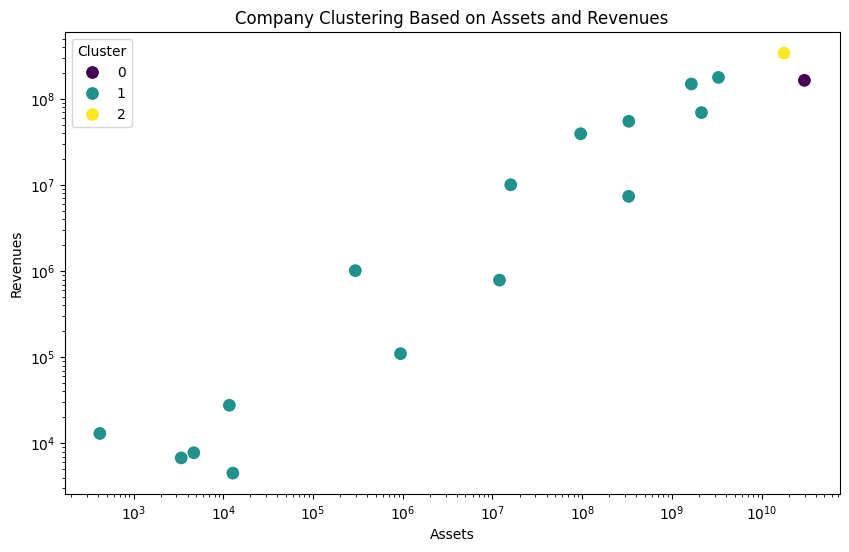

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pivot_health_clean, x='Assets', y='Revenues', hue='cluster', palette='viridis', s=100)
plt.title("Company Clustering Based on Assets and Revenues")
plt.xlabel("Assets")
plt.ylabel("Revenues")
plt.xscale('log')  # Use log scale if needed
plt.yscale('log')  # Use log scale if needed
plt.legend(title='Cluster')
plt.show()


In [ ]:
# Check for invalid numeric entries in the 'value' column
invalid_entries = filtered_num[~filtered_num['value'].str.replace('.', '', regex=False).str.isnumeric()]
print("Invalid Entries in filtered_num:")
print(invalid_entries)


Invalid Entries in filtered_num:
                         adsh            tag       version  \
30842    0000354707-18-000024         Assets  us-gaap/2016   
30843    0000354707-18-000024         Assets  us-gaap/2016   
215809   0001172139-18-000043  NetIncomeLoss  us-gaap/2016   
215810   0001172139-18-000043  NetIncomeLoss  us-gaap/2016   
215811   0001172139-18-000043  NetIncomeLoss  us-gaap/2016   
...                       ...            ...           ...   
9382330  0001144204-18-059189       Revenues  us-gaap/2018   
9382336  0001144204-18-059187       Revenues  us-gaap/2018   
9382621  0000777917-18-000068       Revenues  us-gaap/2018   
9382711  0001144204-18-059185       Revenues  us-gaap/2018   
9382712  0001144204-18-059185       Revenues  us-gaap/2018   

                                                 coreg     ddate qtrs  uom  \
30842    ConsolidationReclassificationsAndEliminations  20161231    0  USD   
30843    ConsolidationReclassificationsAndEliminations  20171231  

In [ ]:
# Convert 'value' to numeric, coercing errors
filtered_num['value'] = pd.to_numeric(filtered_num['value'], errors='coerce')

# Drop rows with NaN values in 'value' after conversion
filtered_num = filtered_num.dropna(subset=['value'])

# Check the cleaned data
print("Cleaned filtered_num:")
print(filtered_num.head())


Cleaned filtered_num:
                       adsh     tag       version coreg     ddate qtrs  uom  \
30525  0001047469-18-002324  Assets  us-gaap/2016   NaN  20161231    0  USD   
30526  0001047469-18-002324  Assets  us-gaap/2016   NaN  20171231    0  USD   
30527  0001453818-18-000012  Assets  us-gaap/2016   NaN  20161231    0  USD   
30528  0001453818-18-000012  Assets  us-gaap/2016   NaN  20170630    0  USD   
30529  0000914748-18-000005  Assets  us-gaap/2016   NaN  20151231    0  USD   

              value footnote  
30525  1.070111e+10      NaN  
30526  1.092814e+10      NaN  
30527  3.988432e+09      NaN  
30528  3.765615e+09      NaN  
30529  1.668895e+10      NaN  


<ipython-input-20-7d0dd094cf4f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_num['value'] = pd.to_numeric(filtered_num['value'], errors='coerce')


In [ ]:

# Calculate the mean and standard deviation for each tag per company
mean_std = filtered_num.groupby(['adsh', 'tag'])['value'].agg(['mean', 'std']).reset_index()

# Merge to find deviations from the mean
merged_data = pd.merge(filtered_num, mean_std, on=['adsh', 'tag'], how='left')
merged_data['deviation'] = (merged_data['value'] - merged_data['mean']) / merged_data['std']

# Filter for significant deviations (e.g., absolute deviation > 2)
anomalies = merged_data[merged_data['deviation'].abs() > 2]
print("Anomalies detected:")
print(anomalies.head())


Anomalies detected:
                      adsh            tag       version  \
302   0000354707-18-000024         Assets  us-gaap/2016   
1212  0000065984-18-000072         Assets  us-gaap/2016   
1213  0000065984-18-000072         Assets  us-gaap/2016   
1726  0000833444-18-000008         Assets  us-gaap/2016   
2190  0001115055-18-000012  NetIncomeLoss  us-gaap/2016   

                         coreg     ddate qtrs  uom         value footnote  \
302                        NaN  20171231    0  USD  1.309983e+10      NaN   
1212                       NaN  20161231    0  USD  4.590443e+10      NaN   
1213                       NaN  20171231    0  USD  4.670715e+10      NaN   
1726  NonGuarantorSubsidiaries  20171231    0  USD  8.177500e+10      NaN   
2190                       NaN  20171231    4  USD  1.739795e+08      NaN   

              mean           std  deviation  
302   4.200667e+09  4.431685e+09   2.008076  
1212  1.251109e+10  1.530231e+10   2.182242  
1213  1.251109e+10  1.53

In [ ]:
# Calculate the mean and standard deviation for each tag per company
mean_std = filtered_num.groupby(['adsh', 'tag'])['value'].agg(['mean', 'std']).reset_index()

# Merge to find deviations from the mean
merged_data = pd.merge(filtered_num, mean_std, on=['adsh', 'tag'], how='left')
merged_data['deviation'] = (merged_data['value'].astype(float) - merged_data['mean'].astype(float)) / merged_data['std'].astype(float)

# Filter for significant deviations (e.g., absolute deviation > 2)
anomalies = merged_data[merged_data['deviation'].abs() > 2]
anomalies.head()

adsh            tag       version  \
302   0000354707-18-000024         Assets  us-gaap/2016   
1212  0000065984-18-000072         Assets  us-gaap/2016   
1213  0000065984-18-000072         Assets  us-gaap/2016   
1726  0000833444-18-000008         Assets  us-gaap/2016   
2190  0001115055-18-000012  NetIncomeLoss  us-gaap/2016   

                         coreg     ddate qtrs  uom         value footnote  \
302                        NaN  20171231    0  USD  1.309983e+10      NaN   
1212                       NaN  20161231    0  USD  4.590443e+10      NaN   
1213                       NaN  20171231    0  USD  4.670715e+10      NaN   
1726  NonGuarantorSubsidiaries  20171231    0  USD  8.177500e+10      NaN   
2190                       NaN  20171231    4  USD  1.739795e+08      NaN   

              mean           std  deviation  
302   4.200667e+09  4.431685e+09   2.008076  
1212  1.251109e+10  1.530231e+10   2.182242  
1213  1.251109e+10  1.530231e+10   2.234699  
1726  4.529700e+10  1.773337e+10   2.057026  
2190  6.611898e+07  5.265807e+07   2.048319

In [ ]:
# Re-create company nodes with unique companies
company_nodes = filtered_num[['adsh', 'tag']].drop_duplicates().merge(combined_dfs['sub.txt'][['adsh', 'cik', 'name']], on='adsh', how='left')
company_nodes = company_nodes[['cik', 'name']].drop_duplicates()
company_nodes.reset_index(drop=True, inplace=True)

# Print the company nodes DataFrame to confirm
print("Company Nodes:")
print(company_nodes.head())

# Create financial metric nodes from filtered_num
financial_metric_nodes = filtered_num[['adsh', 'tag', 'value']].drop_duplicates()

# Print the financial metric nodes DataFrame to confirm
print("Financial Metric Nodes:")
print(financial_metric_nodes.head())


Company Nodes:
       cik                              name
0   788816             OGLETHORPE POWER CORP
1  1453818           HINES GLOBAL REIT, INC.
2   914748  EVEREST REINSURANCE HOLDINGS INC
3  1087022             ALR TECHNOLOGIES INC.
4  1001614                      TENGASCO INC
Financial Metric Nodes:
                       adsh     tag         value
30525  0001047469-18-002324  Assets  1.070111e+10
30526  0001047469-18-002324  Assets  1.092814e+10
30527  0001453818-18-000012  Assets  3.988432e+09
30528  0001453818-18-000012  Assets  3.765615e+09
30529  0000914748-18-000005  Assets  1.668895e+10


In [ ]:
# Count unique company nodes
unique_company_nodes = company_nodes['cik'].nunique()
print("Number of unique company nodes:", unique_company_nodes)

# Count unique financial metric nodes
unique_financial_metric_nodes = financial_metric_nodes['adsh'].nunique()
print("Number of unique financial metric nodes:", unique_financial_metric_nodes)

# Count the number of relationships
number_of_relationships = financial_metric_nodes.shape[0]
print("Number of relationships:", number_of_relationships)

# Check against Neo4j free limits
free_node_limit = 200000
free_relationship_limit = 400000

if unique_company_nodes + unique_financial_metric_nodes <= free_node_limit:
    print("Total nodes within limit.")
else:
    print("Warning: Total nodes exceed free limit.")

if number_of_relationships <= free_relationship_limit:
    print("Total relationships within limit.")
else:
    print("Warning: Total relationships exceed free limit.")


Number of unique company nodes: 7100
Number of unique financial metric nodes: 26279
Number of relationships: 208572
Total nodes within limit.
Total relationships within limit.


In [ ]:
print(company_nodes.head())
print(financial_metric_nodes.head())


       cik                              name
0   788816             OGLETHORPE POWER CORP
1  1453818           HINES GLOBAL REIT, INC.
2   914748  EVEREST REINSURANCE HOLDINGS INC
3  1087022             ALR TECHNOLOGIES INC.
4  1001614                      TENGASCO INC
                       adsh     tag         value
30525  0001047469-18-002324  Assets  1.070111e+10
30526  0001047469-18-002324  Assets  1.092814e+10
30527  0001453818-18-000012  Assets  3.988432e+09
30528  0001453818-18-000012  Assets  3.765615e+09
30529  0000914748-18-000005  Assets  1.668895e+10


In [ ]:
print("Company Nodes Shape:", company_nodes.shape)
print("Financial Metric Nodes Shape:", financial_metric_nodes.shape)


Company Nodes Shape: (7352, 2)
Financial Metric Nodes Shape: (208572, 3)


In [ ]:
def load_company_nodes(session, company_data):
    for index, row in company_data.iterrows():
        try:
            session.run("""
                MERGE (c:Company {cik: $cik})
                SET c.name = $name
            """, cik=row['cik'], name=row['name'])
            print(f"Loaded Company: {row['cik']} - {row['name']}")
        except Exception as e:
            print(f"Error loading company {row['cik']}: {e}")

def load_financial_metric_nodes(session, financial_data):
    for index, row in financial_data.iterrows():
        try:
            session.run("""
                MERGE (f:FinancialMetric {adsh: $adsh, tag: $tag})
                SET f.value = $value
            """, adsh=row['adsh'], tag=row['tag'], value=row['value'])
            print(f"Loaded Financial Metric: {row['adsh']} - {row['tag']} - {row['value']}")
        except Exception as e:
            print(f"Error loading financial metric {row['adsh']} - {row['tag']}: {e}")


In [ ]:
# Check for missing values in combined sub.txt
print("Missing values in sub.txt:")
print(combined_dfs['sub.txt'].isnull().sum())

# Check for missing values in combined num.txt
print("\nMissing values in num.txt:")
print(combined_dfs['num.txt'].isnull().sum())

# Check for duplicates in sub.txt based on 'adsh'
print("\nDuplicate filings in sub.txt:")
duplicate_sub = combined_dfs['sub.txt'][combined_dfs['sub.txt'].duplicated(subset=['adsh'], keep=False)]
print(duplicate_sub)

# Check for duplicates in num.txt based on 'adsh' and 'tag' (this combination should be unique for each entry)
print("\nDuplicate financial entries in num.txt:")
duplicate_num = combined_dfs['num.txt'][combined_dfs['num.txt'].duplicated(subset=['adsh', 'tag'], keep=False)]
print(duplicate_num)


Missing values in sub.txt:
adsh              0
cik               0
name              0
sic              19
countryba        53
stprba         2542
cityba           54
zipba            71
bas1             52
bas2          14790
baph             52
countryma       190
stprma         2537
cityma          188
zipma           198
mas1            188
mas2          14951
countryinc     2318
stprinc        3592
ein               4
former        11850
changed       11850
afs             100
wksi              0
fye               9
form              0
period            0
fy              482
fp              567
filed             0
accepted          0
prevrpt           0
detail            0
instance          0
nciks             0
aciks         25885
dtype: int64

Missing values in num.txt:
adsh              0
tag               0
version           0
coreg       9431955
ddate             0
qtrs              0
uom               0
value        224090
footnote    9829914
dtype: int64

Duplicate filings 

In [ ]:
# Fill or drop missing values in sub.txt
sub_df_cleaned = combined_dfs['sub.txt'].dropna(subset=['adsh'])  # Drop rows where adsh is missing

# Use .loc to directly modify the DataFrame, which avoids the chained assignment warning
sub_df_cleaned.loc[:, 'sic'] = sub_df_cleaned['sic'].fillna('Unknown')  # For categorical data
sub_df_cleaned.loc[:, 'countryba'] = sub_df_cleaned['countryba'].fillna('Unknown')  # Fill missing country information
sub_df_cleaned.loc[:, 'cityba'] = sub_df_cleaned['cityba'].fillna('Unknown')

# Fill missing numerical columns with 0 (where applicable)
sub_df_cleaned.loc[:, 'stprba'] = sub_df_cleaned['stprba'].fillna(0)

# Repeat for num.txt
num_df_cleaned = combined_dfs['num.txt'].dropna(subset=['adsh', 'tag'])  # Drop rows missing critical identifiers

# Use .loc to fill missing values in financial data (e.g., value) with a placeholder (-1 or another flag)
num_df_cleaned.loc[:, 'value'] = num_df_cleaned['value'].fillna(-1)

print("Remaining missing values after cleaning in sub.txt:")
print(sub_df_cleaned.isnull().sum())

print("\nRemaining missing values after cleaning in num.txt:")
print(num_df_cleaned.isnull().sum())


Remaining missing values after cleaning in sub.txt:
adsh              0
cik               0
name              0
sic               0
countryba         0
stprba            0
cityba            0
zipba            71
bas1             52
bas2          14790
baph             52
countryma       190
stprma         2537
cityma          188
zipma           198
mas1            188
mas2          14951
countryinc     2318
stprinc        3592
ein               4
former        11850
changed       11850
afs             100
wksi              0
fye               9
form              0
period            0
fy              482
fp              567
filed             0
accepted          0
prevrpt           0
detail            0
instance          0
nciks             0
aciks         25885
dtype: int64

Remaining missing values after cleaning in num.txt:
adsh              0
tag               0
version           0
coreg       9431955
ddate             0
qtrs              0
uom               0
value             0
fo

In [ ]:
# Check for missing values in company data
print("Missing values in company data:")
print(sub_df_combined.isnull().sum())

# Check for missing values in aggregated financial data
print("Missing values in financial data:")
print(num_df_combined.isnull().sum())

# Check for duplicates in company data
duplicates_companies = sub_df_combined[sub_df_combined.duplicated(subset=['adsh'], keep=False)]
print("Duplicate companies:")
print(duplicates_companies)

# Check for duplicates in financial data without 'year'
duplicates_financials = num_df_combined[num_df_combined.duplicated(subset=['adsh', 'tag'], keep=False)]
print("Duplicate financial entries:")
print(duplicates_financials)



Missing values in company data:
adsh              0
cik               0
name              0
sic              19
countryba        53
stprba         2542
cityba           54
zipba            71
bas1             52
bas2          14790
baph             52
countryma       190
stprma         2537
cityma          188
zipma           198
mas1            188
mas2          14951
countryinc     2318
stprinc        3592
ein               4
former        11850
changed       11850
afs             100
wksi              0
fye               9
form              0
period            0
fy              482
fp              567
filed             0
accepted          0
prevrpt           0
detail            0
instance          0
nciks             0
aciks         25885
dtype: int64
Missing values in financial data:
adsh              0
tag               0
version           0
coreg       9431955
ddate             0
qtrs              0
uom               0
value        224090
footnote    9829914
dtype: int64
Duplicat

In [ ]:
# Example of handling missing values in company data
sub_df_combined['countryba'].fillna('Unknown', inplace=True)  # Fill with "Unknown"
sub_df_combined['stprba'].fillna(sub_df_combined['stprba'].mode()[0], inplace=True)  # Fill with mode

# Flagging missing values
sub_df_combined['countryba_missing'] = sub_df_combined['countryba'].isnull()
sub_df_combined['stprba_missing'] = sub_df_combined['stprba'].isnull()

# Fill missing values for numeric fields in financial data
num_df_combined['value'].fillna(-1, inplace=True)  # Fill with -1 or another placeholder


<ipython-input-48-a6a6af460b55>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sub_df_combined['countryba'].fillna('Unknown', inplace=True)  # Fill with "Unknown"
<ipython-input-48-a6a6af460b55>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

In [ ]:
# Fill missing values in company data
sub_df_combined['countryba'] = sub_df_combined['countryba'].fillna('Unknown')  # Fill with "Unknown"
sub_df_combined['stprba'] = sub_df_combined['stprba'].fillna(sub_df_combined['stprba'].mode()[0])  # Fill with mode

# Flagging missing values
sub_df_combined['countryba_missing'] = sub_df_combined['countryba'].isnull()
sub_df_combined['stprba_missing'] = sub_df_combined['stprba'].isnull()

# Fill missing values for numeric fields in financial data
num_df_combined['value'] = num_df_combined['value'].fillna(-1)  # Fill with -1 or another placeholder


In [ ]:
# Fill missing values in company data using .loc
sub_df_combined.loc[sub_df_combined['countryba'].isnull(), 'countryba'] = 'Unknown'
sub_df_combined.loc[sub_df_combined['stprba'].isnull(), 'stprba'] = sub_df_combined['stprba'].mode()[0]

# Flagging missing values
sub_df_combined['countryba_missing'] = sub_df_combined['countryba'].isnull()
sub_df_combined['stprba_missing'] = sub_df_combined['stprba'].isnull()

# Fill missing values for numeric fields in financial data
num_df_combined.loc[num_df_combined['value'].isnull(), 'value'] = -1  # Fill with -1 or another placeholder


In [ ]:
# Verify remaining missing values in company data
print("Remaining missing values in company data:")
print(sub_df_combined.isnull().sum())

# Verify remaining missing values in financial data
print("Remaining missing values in financial data:")
print(num_df_combined.isnull().sum())


Remaining missing values in company data:
adsh                     0
cik                      0
name                     0
sic                     19
countryba                0
stprba                   0
cityba                  54
zipba                   71
bas1                    52
bas2                 14790
baph                    52
countryma              190
stprma                2537
cityma                 188
zipma                  198
mas1                   188
mas2                 14951
countryinc            2318
stprinc               3592
ein                      4
former               11850
changed              11850
afs                    100
wksi                     0
fye                      9
form                     0
period                   0
fy                     482
fp                     567
filed                    0
accepted                 0
prevrpt                  0
detail                   0
instance                 0
nciks                    0
aciks        

In [ ]:
# Check for duplicates in company data
duplicates_companies = sub_df_combined[sub_df_combined.duplicated(subset=['adsh'], keep=False)]
print("Duplicate companies:")
print(duplicates_companies)

# Check for duplicates in financial data
duplicates_financials = num_df_combined[num_df_combined.duplicated(subset=['adsh', 'tag'], keep=False)]
print("Duplicate financial entries:")
print(duplicates_financials)


Duplicate companies:
Empty DataFrame
Columns: [adsh, cik, name, sic, countryba, stprba, cityba, zipba, bas1, bas2, baph, countryma, stprma, cityma, zipma, mas1, mas2, countryinc, stprinc, ein, former, changed, afs, wksi, fye, form, period, fy, fp, filed, accepted, prevrpt, detail, instance, nciks, aciks, countryba_missing, stprba_missing]
Index: []

[0 rows x 38 columns]
Duplicate financial entries:
                         adsh  \
131      0000815097-18-000005   
132      0000815097-18-000005   
155      0001166691-18-000004   
156      0001166691-18-000004   
253      0001558370-18-000535   
...                       ...   
9851768  0000320193-18-000145   
9851769  0000320193-18-000145   
9851770  0000320193-18-000145   
9851771  0000320193-18-000145   
9851772  0000320193-18-000145   

                                                       tag  \
131                                      EntityPublicFloat   
132                                      EntityPublicFloat   
155           

In [ ]:
# Check the shapes of the cleaned DataFrames
print("Shape of cleaned company data:", sub_df_combined.shape)
print("Shape of cleaned financial data:", num_df_combined.shape)

# Display sample data for final verification
print("Sample of cleaned company data:")
print(sub_df_combined.sample(5))

print("Sample of cleaned financial data:")
print(num_df_combined.sample(5))


Shape of cleaned company data: (26396, 38)
Shape of cleaned financial data: (9851780, 9)
Sample of cleaned company data:
                       adsh      cik  \
15662  0001193125-18-239600  1158895   
2185   0000040545-18-000014    40545   
1364   0001213900-18-001850  1479526   
24434  0001654954-18-012525   927761   
13123  0001558370-18-005271  1593936   

                                              name     sic countryba stprba  \
15662                        LEMAITRE VASCULAR INC  3841.0        US     MA   
2185                           GENERAL ELECTRIC CO  3600.0        US     MA   
1364   CHINA MODERN AGRICULTURAL INFORMATION, INC.  5013.0        CN     CA   
24434                                MYMETICS CORP  2836.0        CH     CA   
13123                     MICHAELS COMPANIES, INC.  5945.0        US     TX   

                     cityba    zipba                       bas1  \
15662            BURLINGTON    01803           63 SECOND AVENUE   
2185                 BOSTON  

In [ ]:
sub_df_combined['sic'].fillna('Unknown', inplace=True)  # Fill with "Unknown"
sub_df_combined['cityba'].fillna('Unknown', inplace=True)  # Fill with "Unknown"
sub_df_combined['zipba'].fillna('Unknown', inplace=True)  # Fill with "Unknown"


<ipython-input-54-d900b246e788>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sub_df_combined['sic'].fillna('Unknown', inplace=True)  # Fill with "Unknown"
<ipython-input-54-d900b246e788>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  sub_df_combined['sic'].fillna('Unknown', inplace=True)  # Fill with "Unknown"
<ipython-input-54-d900b246e788>

In [ ]:
num_df_combined.drop_duplicates(subset=['adsh', 'tag', 'ddate'], keep='first', inplace=True)


In [ ]:
# Check for remaining missing values
print("Remaining missing values in company data:")
print(sub_df_combined.isnull().sum())
print("Remaining missing values in financial data:")
print(num_df_combined.isnull().sum())

# Verify the shape of cleaned DataFrames
print("Shape of cleaned company data:", sub_df_combined.shape)
print("Shape of cleaned financial data:", num_df_combined.shape)


Remaining missing values in company data:
adsh                     0
cik                      0
name                     0
sic                      0
countryba                0
stprba                   0
cityba                   0
zipba                    0
bas1                    52
bas2                 14790
baph                    52
countryma              190
stprma                2537
cityma                 188
zipma                  198
mas1                   188
mas2                 14951
countryinc            2318
stprinc               3592
ein                      4
former               11850
changed              11850
afs                    100
wksi                     0
fye                      9
form                     0
period                   0
fy                     482
fp                     567
filed                    0
accepted                 0
prevrpt                  0
detail                   0
instance                 0
nciks                    0
aciks        

In [ ]:
# Filter numeric data for key metrics (e.g., Revenue, NetIncome, Debt)
key_metrics = ['Revenue', 'NetIncome', 'Debt']
num_df_filtered = num_df_combined[num_df_combined['tag'].isin(key_metrics)]
print(num_df_filtered.shape)  # Check how much the dataset has been reduced


(1345, 9)


In [ ]:
# Add a 'year' column from the 'ddate' column
num_df_filtered['year'] = num_df_filtered['ddate'].astype(str).str[:4]

# Aggregate financial data by 'adsh', 'year', and 'tag', summing up the values
num_df_aggregated = num_df_filtered.groupby(['adsh', 'year', 'tag'])['value'].sum().reset_index()
print(num_df_aggregated.shape)  # Check the shape after aggregation


(1310, 4)


<ipython-input-58-bb934a9cce6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df_filtered['year'] = num_df_filtered['ddate'].astype(str).str[:4]


In [ ]:
# Get the top 1000 companies by total revenue (optional)
top_companies = num_df_aggregated[num_df_aggregated['tag'] == 'Revenue'].groupby('adsh')['value'].sum().nlargest(1000).index
sub_df_sampled = sub_df_combined[sub_df_combined['adsh'].isin(top_companies)]
print(sub_df_sampled.shape)


(493, 38)


In [ ]:
# Summary statistics for each financial metric
print(num_df_aggregated.groupby('tag')['value'].describe())


            count          mean           std           min           25%  \
tag                                                                         
Debt         21.0  5.147744e+09  4.486657e+09  1.414943e+09  2.741000e+09   
NetIncome    17.0  1.120680e+08  3.425109e+08 -3.700000e+07  3.400000e+05   
Revenue    1272.0  7.361178e+11  5.279140e+12 -1.000000e+00  1.567670e+08   

                    50%           75%           max  
tag                                                  
Debt       3.511000e+09  6.100000e+09  1.872600e+10  
NetIncome  2.481000e+06  3.775000e+06  1.234507e+09  
Revenue    2.830450e+09  2.340165e+10  6.018687e+13  


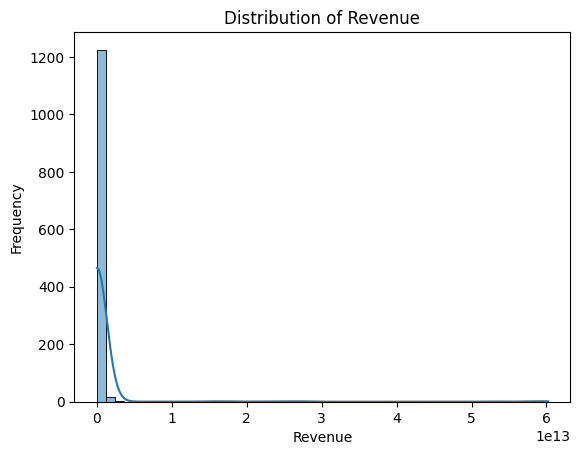

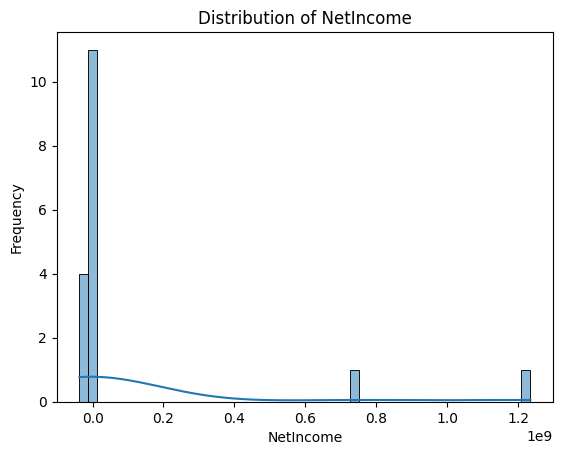

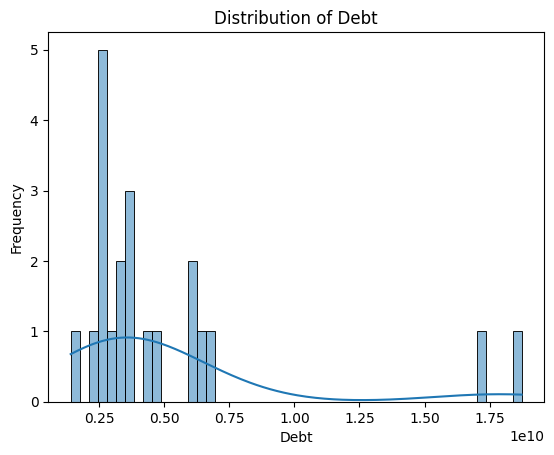

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution for each financial metric
for metric in key_metrics:
    metric_data = num_df_aggregated[num_df_aggregated['tag'] == metric]['value']
    sns.histplot(metric_data, bins=50, kde=True)
    plt.title(f"Distribution of {metric}")
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.show()


In [ ]:
# Top 10 companies by total revenue
top_companies_by_revenue = num_df_aggregated[num_df_aggregated['tag'] == 'Revenue'].groupby('adsh')['value'].sum().nlargest(10)
print(top_companies_by_revenue)


adsh
0001193125-18-141125    1.776807e+14
0001193125-18-136684    1.716489e+14
0001144204-18-022451    1.567871e+14
0001193125-18-136619    8.267817e+13
0001144204-18-022931    7.370868e+13
0001193125-18-141554    6.936766e+13
0001193125-18-151612    5.174856e+13
0001193125-18-197283    4.396150e+13
0001193125-18-136720    1.763712e+13
0001564590-18-014454    7.390607e+12
Name: value, dtype: float64


In [ ]:
# Check for the maximum value in the original filtered numeric data
max_value = num_df_filtered['value'].max()
print("Maximum value in filtered data:", max_value)

# Check entries in the original DataFrame corresponding to large values
large_values = num_df_filtered[num_df_filtered['value'] > 1e13]  # Adjust threshold as necessary
print("Entries with very high values:")
print(large_values)


Maximum value in filtered data: 60186867000000.0
Entries with very high values:
                         adsh      tag    version coreg     ddate  qtrs  uom  \
4819577  0001193125-18-136720  Revenue  ifrs/2017   NaN  20171231     4  KRW   
4819591  0001144204-18-022451  Revenue  ifrs/2017   NaN  20151231     4  COP   
4819592  0001144204-18-022451  Revenue  ifrs/2017   NaN  20161231     4  COP   
4819593  0001144204-18-022451  Revenue  ifrs/2017   NaN  20171231     4  COP   
4819691  0001193125-18-136684  Revenue  ifrs/2017   NaN  20161231     4  KRW   
4819692  0001193125-18-136684  Revenue  ifrs/2017   NaN  20171231     4  KRW   
4819693  0001193125-18-136684  Revenue  ifrs/2017   NaN  20151231     4  KRW   
4819715  0001193125-18-136619  Revenue  ifrs/2017   NaN  20151231     4  KRW   
4819716  0001193125-18-136619  Revenue  ifrs/2017   NaN  20161231     4  KRW   
4819717  0001193125-18-136619  Revenue  ifrs/2017   NaN  20171231     4  KRW   
4819722  0001144204-18-022931  Revenue  

In [ ]:
# Merge with company names
top_companies_with_names = sub_df_combined.merge(top_companies_by_revenue, on='adsh')
print(top_companies_with_names[['name', 'value']])


                                 name         value
0                      ECOPETROL S.A.  1.567871e+14
1  GRUPO AVAL ACCIONES Y VALORES S.A.  7.370868e+13
2                LG DISPLAY CO., LTD.  8.267817e+13
3                               POSCO  1.716489e+14
4             KB FINANCIAL GROUP INC.  1.763712e+13
5           KOREA ELECTRIC POWER CORP  1.776807e+14
6                             KT CORP  6.936766e+13
7                   SK TELECOM CO LTD  5.174856e+13
8                     ENEL CHILE S.A.  7.390607e+12
9                  HONDA MOTOR CO LTD  4.396150e+13


In [ ]:
# Year-over-year revenue growth for top companies
revenue_df = num_df_aggregated[num_df_aggregated['tag'] == 'Revenue'].pivot_table(index='adsh', columns='year', values='value')
revenue_df['YoY_Growth'] = revenue_df.pct_change(axis='columns').mean(axis=1)

# Top companies with the highest year-over-year revenue growth
top_growth_companies = revenue_df['YoY_Growth'].nlargest(10)
print(top_growth_companies)


adsh
0001279569-18-000556           inf
0001628280-18-004229           inf
0001193125-18-110096    946.471782
0001558370-18-000892     23.779978
0001144204-18-049492      8.225704
0001628280-18-011976      6.991158
0001213900-18-011964      5.632353
0001213900-18-016981      5.626923
0001558370-18-007290      3.865424
0001477932-18-005562      3.718984
Name: YoY_Growth, dtype: float64


<ipython-input-65-4e4abafaf0e5>:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  revenue_df['YoY_Growth'] = revenue_df.pct_change(axis='columns').mean(axis=1)


In [ ]:
import numpy as np
# Year-over-year revenue growth for top companies(handnles inf and NAN)
revenue_df = num_df_aggregated[num_df_aggregated['tag'] == 'Revenue'].pivot_table(index='adsh', columns='year', values='value')

# Calculate year-over-year growth
revenue_df['YoY_Growth'] = revenue_df.pct_change(axis='columns').mean(axis=1)

# Replace inf values with NaN (infinity occurs when dividing by zero)
revenue_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Option 1: Drop companies where YoY_Growth is NaN
revenue_df_cleaned = revenue_df.dropna(subset=['YoY_Growth'])

# Show the cleaned growth data
top_growth_companies = revenue_df_cleaned['YoY_Growth'].nlargest(10)
print(top_growth_companies)


adsh
0001193125-18-110096    946.471782
0001558370-18-000892     23.779978
0001144204-18-049492      8.225704
0001628280-18-011976      6.991158
0001213900-18-011964      5.632353
0001213900-18-016981      5.626923
0001558370-18-007290      3.865424
0001477932-18-005562      3.718984
0001193125-18-140678      3.184116
0001193125-18-359203      2.682887
Name: YoY_Growth, dtype: float64


<ipython-input-66-b431229f802e>:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  revenue_df['YoY_Growth'] = revenue_df.pct_change(axis='columns').mean(axis=1)


In [ ]:
# Check for missing values in the aggregated data
print(num_df_aggregated.isnull().sum())


adsh     0
year     0
tag      0
value    0
dtype: int64


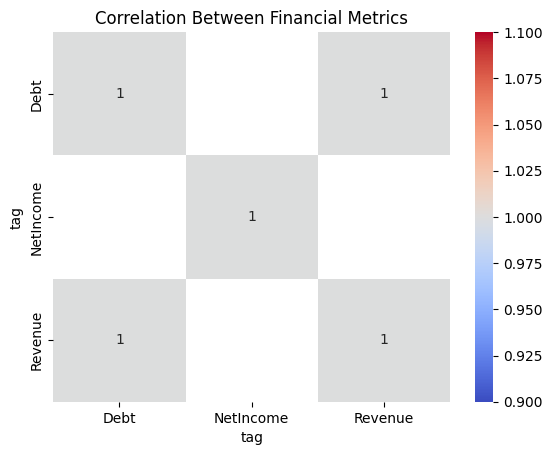

In [ ]:
# Pivot data for correlation analysis
metrics_pivot = num_df_aggregated.pivot_table(index='adsh', columns='tag', values='value')

# Correlation matrix
correlation_matrix = metrics_pivot.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Financial Metrics')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data for Revenue only
revenue_data = num_df_aggregated_cleaned[num_df_aggregated_cleaned['tag'] == 'Revenue']

# Group by company (adsh) and sum the revenue values to get total revenue per company
revenue_per_company = revenue_data.groupby('adsh')['value'].sum().reset_index()

# Merge with company names for easier identification
revenue_per_company = revenue_per_company.merge(sub_df_combined[['adsh', 'name']], on='adsh')

# Sort by revenue for better visualization
revenue_per_company.sort_values(by='value', ascending=False, inplace=True)


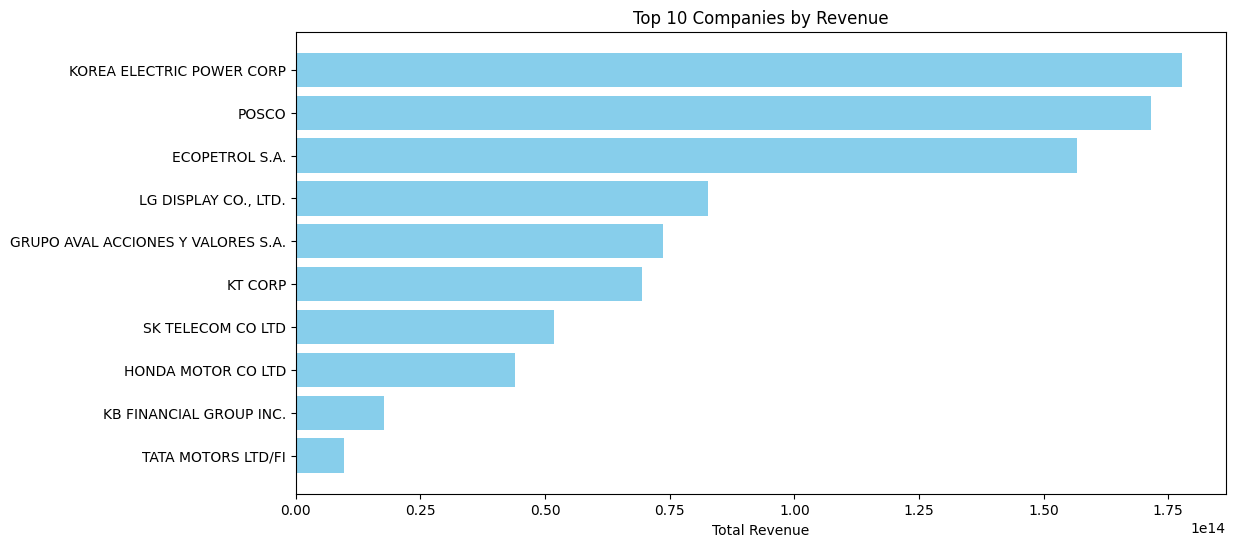

In [ ]:
# Plot the revenue comparison
plt.figure(figsize=(12, 6))
plt.barh(revenue_per_company['name'][:10], revenue_per_company['value'][:10], color='skyblue')  # Show top 10 companies
plt.xlabel('Total Revenue')
plt.title('Top 10 Companies by Revenue')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest revenue on top
plt.show()
